# **Set-up**
We are using MusPy to calculate certain metrics (see code)

In [ ]:
!pip install muspy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Imports
import muspy as mus
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stat
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shareddrives/EC523_Project/CodeWorkspace

/content/drive/Shareddrives/EC523_Project/CodeWorkspace


In [ ]:
mus.download_bravura_font()

Start downloading Bravura font.
Bravura font has successfully been downloaded to : /root/.muspy/musescore-general.


# **Custom Metrics Classes**
In order to streamline our evaluation, we created two different classes, one being "metric" which stores a data vector and can perform basic statistical calculations on said vector, and "metrics" which calculates each metric in the MusPy library and stores it in a "metric"

In [ ]:
# Metric Class -> single metric
class Metric :
  # Init with list, int, float, or another metric
  def __init__(self, data=[]) :
    if isinstance(data,Metric) :
      self.data = data.data
    elif isinstance(data,list) :
      self.data = data
    elif (isinstance(data,int) or isinstance(data,float)) :
      self.data = [data]
    else :
      self.data = []
    self.override = 0; # 1 force inclusion, -1 force exclusion, 0 no change

  # Append function
  def append(self, data) :
    if isinstance(data,Metric) :
      self.data = self.data + data.data
    elif (isinstance(data,list)) :
      self.data = self.data + data.data
    elif (isinstance(data,int) or isinstance(data,float)) :
      self.data = self.data.append(data)
  
  # Return mean
  def mean(self) :
    return np.mean(self.data)

  # Return standard deviation
  def std(self) :
    return np.std(self.data)

  # Return likelihood of given value to fall within data of self
  def pdf(self, data) :
    if (isinstance(data,int) or isinstance(data,float)) :
      return stat.norm(self.mean(), self.std()).pdf(data)
    else :
      return 0

  # Return p score of Shapiro-Wilk test
  def p_score(self) :
    _, p = stat.shapiro(self.data)
    return p

  # Return result of hypothesis test. 1=Hypothesis, 0=Null Hypothesis, -1=insufficiently gaussian, manually ignored
  def hyp_test(self, data, alpha=0.05, ci=0.05) :
    if not isinstance(data,Metric) :
      print("Must pass Metric() instance")
      return -1
    # if p_score is LEQ than specified alpha, not normal, ignore result
    if ((self.p_score()<=alpha and self.override != 1) or self.override == -1):
      return -1
    # Calculate z_score = (x_bar - mu)/(sigma / sqrt(n))
    z_score = abs(data.mean()-self.mean())/(self.std())
    # Calculate if within probability region
    threshold = abs(stat.norm.ppf(1-(ci/2)))

    return 1 if z_score < threshold else 0



In [ ]:
# Metrics class -> collection of metric classes
class Metrics :
    
  def __init__(self, music=0) :
    if isinstance(music, mus.Music) :
      self.pitch_range = Metric(mus.pitch_range(music))
      self.n_pitches_used = Metric(mus.n_pitches_used(music))
      self.n_pitch_classes_used = Metric(mus.n_pitch_classes_used(music))
      self.polyphony = Metric(mus.polyphony(music))
      self.polyphony_rate = Metric(mus.polyphony_rate(music))
      # self.pitch_in_scale_rate = Metric(mus.pitch_in_scale_rate(music))
      self.scale_consistency = Metric(mus.scale_consistency(music))
      self.pitch_entropy = Metric(mus.pitch_entropy(music))
      self.pitch_class_entropy = Metric(mus.pitch_class_entropy(music))
    elif isinstance(music, Metrics) :
      self = music
    else :
      self.pitch_range = Metric()
      self.n_pitches_used = Metric()
      self.n_pitch_classes_used = Metric()
      self.polyphony = Metric()
      self.polyphony_rate = Metric()
      # self.pitch_in_scale_rate = Metric()
      self.scale_consistency = Metric()
      self.pitch_entropy = Metric()
      self.pitch_class_entropy = Metric()

  def append(self, data) :
    if isinstance(data, Metrics) :
      for attr in dir(Metrics()) :
        if not callable(getattr(self, attr)) and not attr.startswith("__") :
          getattr(self,attr).append(getattr(data,attr))
    else :
      print("Must be of class Metrics")

  def print_mean(self) :
    for attr in dir(Metrics()) :
      if not callable(getattr(self, attr)) and not attr.startswith("__") :
        print("%-20s : %s" % (attr, str(getattr(self,attr).mean())))

  def print_std(self) :
    for attr in dir(Metrics()) :
      if not callable(getattr(self, attr)) and not attr.startswith("__") :
        print("%-20s : %s" % (attr, str(getattr(self,attr).std())))
        
  def print_pdf(self, data) :
    for attr in dir(Metrics()) :
      if not callable(getattr(self, attr)) and not attr.startswith("__") :
        print("%-20s : %s" % (attr, str(getattr(self,attr).pdf(getattr(data,attr)))))
  
  def print_p(self) : 
    for attr in dir(Metrics()) :
      if not callable(getattr(self, attr)) and not attr.startswith("__") :
        print("%-20s : %s" % (attr, str(getattr(self,attr).p_score())))

  def print_hyp_test(self, data, alpha=0.05, ci=0.05) :
    for attr in dir(Metrics()) :
      if not callable(getattr(self, attr)) and not attr.startswith("__") :
        print("%-20s : %s" % (attr, str(getattr(self,attr).hyp_test(getattr(data,attr),alpha,ci))))

  def plot_attr(self) :
    for attr in dir(Metrics()) :
      if not callable(getattr(self, attr)) and not attr.startswith("__") :
        plt.hist(getattr(self, attr).data)
        plt.title(f"Hist of {attr}")
        plt.show()

# **Evaluative functions**
Used for ingesting and processing data, be it in the form of a pianoroll or as a series of chords

In [ ]:
# Data Processing Functions and classes

# Converts the list (from CSV) into a track
def chords2track(note_list) :
  # Input array should be a list of length C of lists of length N of integers, where each integer corresponds to the MIDI value. The specific note these correspond to is not important
  track = mus.Track() # Create empty track

  # For every chord
  for c in range(len(note_list)) :
    # For every note in chord
    for n in range(len(note_list[c])) : 
      track.append(mus.Note(c,note_list[c][n],1))
  
  return track

# Converts the pianoroll into a track
def pianoroll2track(note_list) :
  # Input array should be a list of length C of lists of length N of integers, where each integer corresponds to the MIDI value. The specific note these correspond to is not important
  track = mus.Track() # Create empty track
  
  # For every pitch 0-127
  for p in range(note_list.shape[0]) :
    start = 0
    duration = 0
    # For every timestep
    for t in range(note_list.shape[1]) : 
      # if previous velocity is 0 and current is >0, is beginning of note
      #    if not first timestep                                       if first timestep
      if ((t>0 and note_list[p][t-1] == 0 and note_list[p][t] > 0) or (t==0 and note_list[p][t] > 0)) :
        start = t
      # else, if previous velocity is >0 and current is 0, is end of note
      #      if not first or last timestep                                                            if last timestep
      elif ((t>0 and t<(note_list.shape[1]-1) and note_list[p][t-1] > 0 and note_list[p][t] == 0) or (t==(note_list.shape[1]-1) and note_list[p][t-1] > 0 and note_list[p][t] > 0)) :
        duration = t-start
        track.append(mus.Note(start,p,duration))
      # else, do nothing

  return track


def getMetricsChords(note_list, res=4) :
  # resolution of dataset is 16th notes, therefore resolution is 4/quarter
  music = mus.Music(resolution=res,tracks=[chords2track(note_list)])

  # return metrics object
  return Metrics(music)

def getMetricsPianoroll(note_list, res=10) :
  music = mus.Music(resolution=res,tracks=[pianoroll2track(note_list)])
  
  # return metrics object
  return Metrics(music)


# **Calculating for the Bach Chorals**


## Characterize Training Set

In [ ]:
# Compile metrics of all training tracks
import pandas as pd 
num_tracks = 400
PATH_STUB = '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/BachChorales/'

# Get metrics on training dataset
training_metrics = Metrics()
for t in range(num_tracks) :
  note_list = []
  # Read CSV from one of 3 folders on path
  try :
    note_list = pd.read_csv(PATH_STUB+f'train/chorale_{t:03}'+'.csv')
  except :
    continue
  note_list = note_list.values.tolist()
  # Append recorded metrics
  training_metrics.append(getMetricsChords(note_list))

# # Manually Choose metrics
# training_metrics.n_pitch_classes_used.override  = -1
# training_metrics.n_pitches_used.override        = 1
# training_metrics.pitch_class_entropy.override   = 1
# training_metrics.pitch_entropy.override         = 1
# training_metrics.pitch_range.override           = -1
# training_metrics.polyphony.override             = -1
# training_metrics.polyphony_rate.override        = -1
# training_metrics.scale_consistency.override     = 1

## Characterize validation set

In [ ]:
# Get metrics on validation dataset
valid_metrics = Metrics()
for t in range(num_tracks) :
  note_list = []
  # Read CSV from one of 3 folders on path
  try :
    note_list = pd.read_csv(PATH_STUB+f'valid/chorale_{t:03}'+'.csv')
  except :
    continue
  note_list = note_list.values.tolist()
  # Append recorded metrics
  valid_metrics.append(getMetricsChords(note_list))

## Characterize testing set

In [ ]:
# Get metrics on testing dataset
test_metrics = Metrics()
for t in range(num_tracks) :
  note_list = []
  # Read CSV from one of 3 folders on path
  try :
    note_list = pd.read_csv(PATH_STUB+f'test/chorale_{t:03}'+'.csv')
  except :
    continue
  note_list = note_list.values.tolist()
  # Append recorded metrics
  test_metrics.append(getMetricsChords(note_list))

## Save data

In [ ]:
# Save Data for later
import pickle

def save_object(obj,name="data",path="/content/drive/Shareddrives/EC523_Project/CodeWorkspace/BachMetrics/"):
    try:
        f = open((path + name + ".pickle"), "wb")
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)

save_object(training_metrics, "training_metrics")
save_object(valid_metrics, "validation_metrics")
save_object(test_metrics, "testing_metrics")

In [ ]:
# Load Data
import pickle

def load_object(filename, path="/content/drive/Shareddrives/EC523_Project/CodeWorkspace/BachMetrics/"):
    try:
        with open(path + filename+".pickle", "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)

bach_training_metrics = load_object("training_metrics")
bach_validation_metrics = load_object("validation_metrics")
bach_testing_metrics = load_object("testing_metrics")

## Evaluate

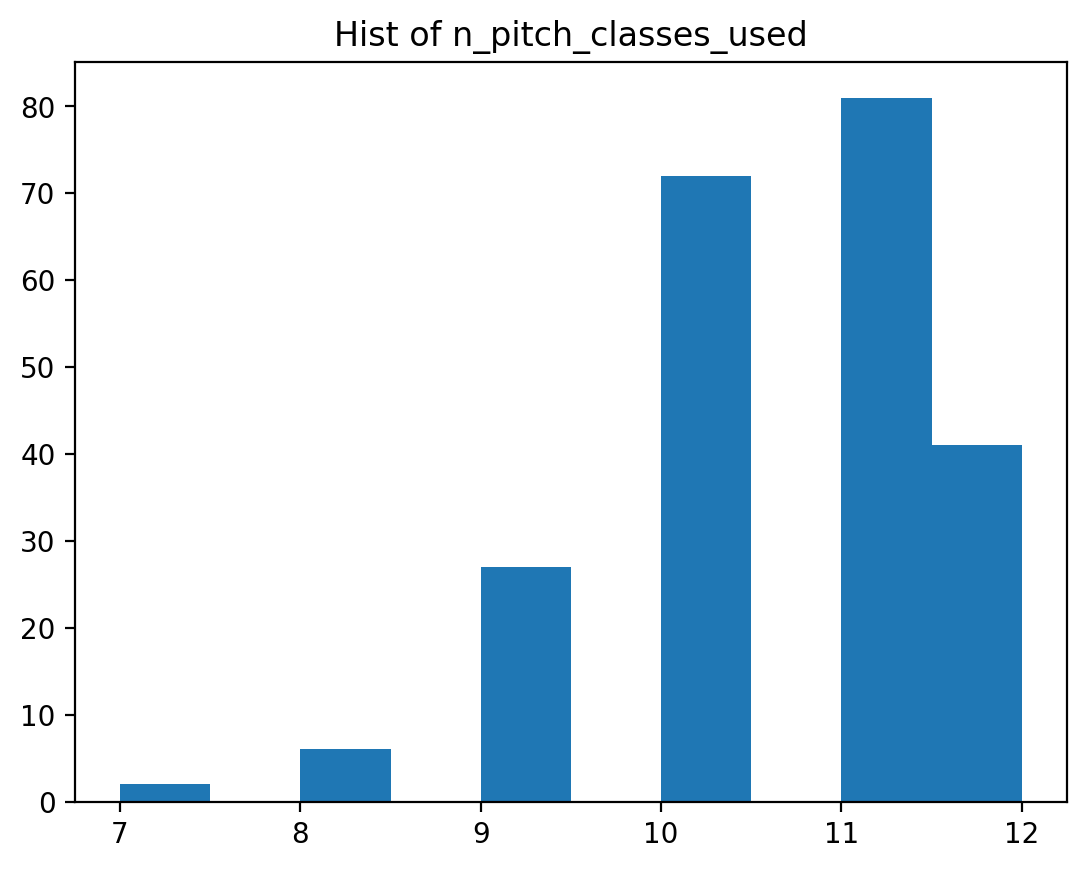

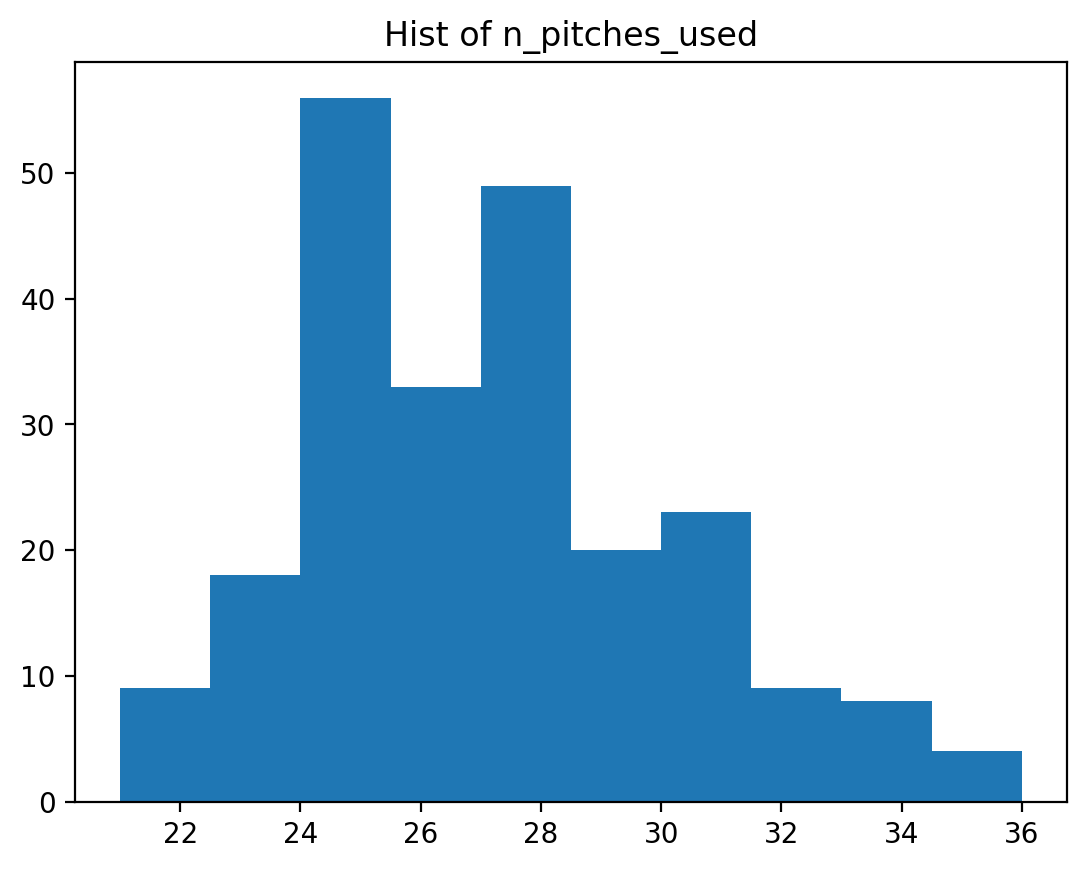

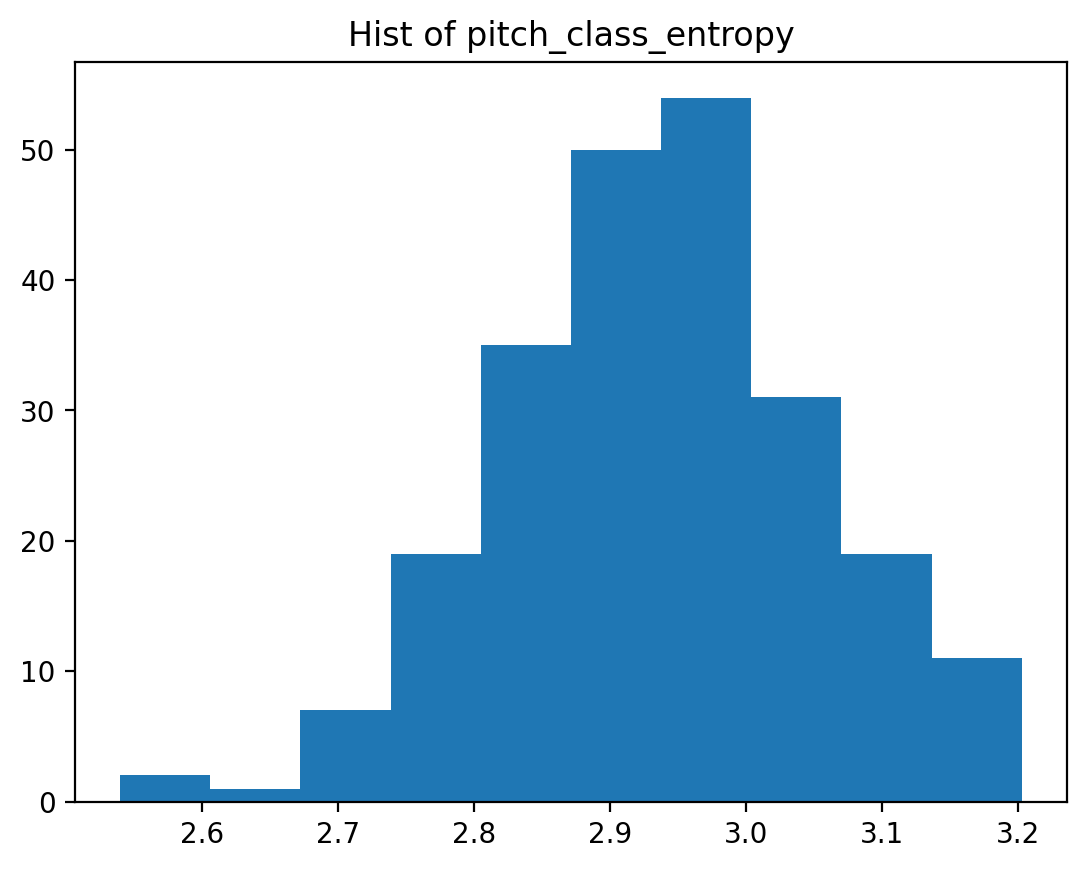

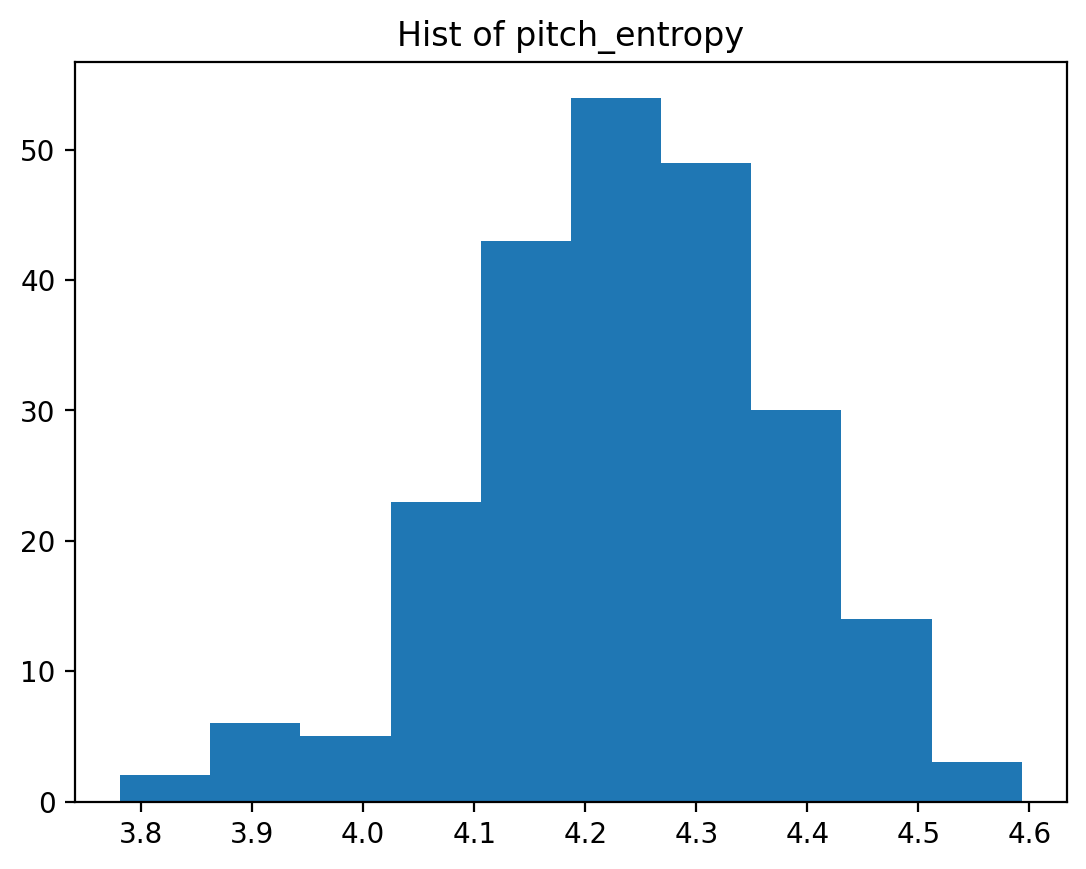

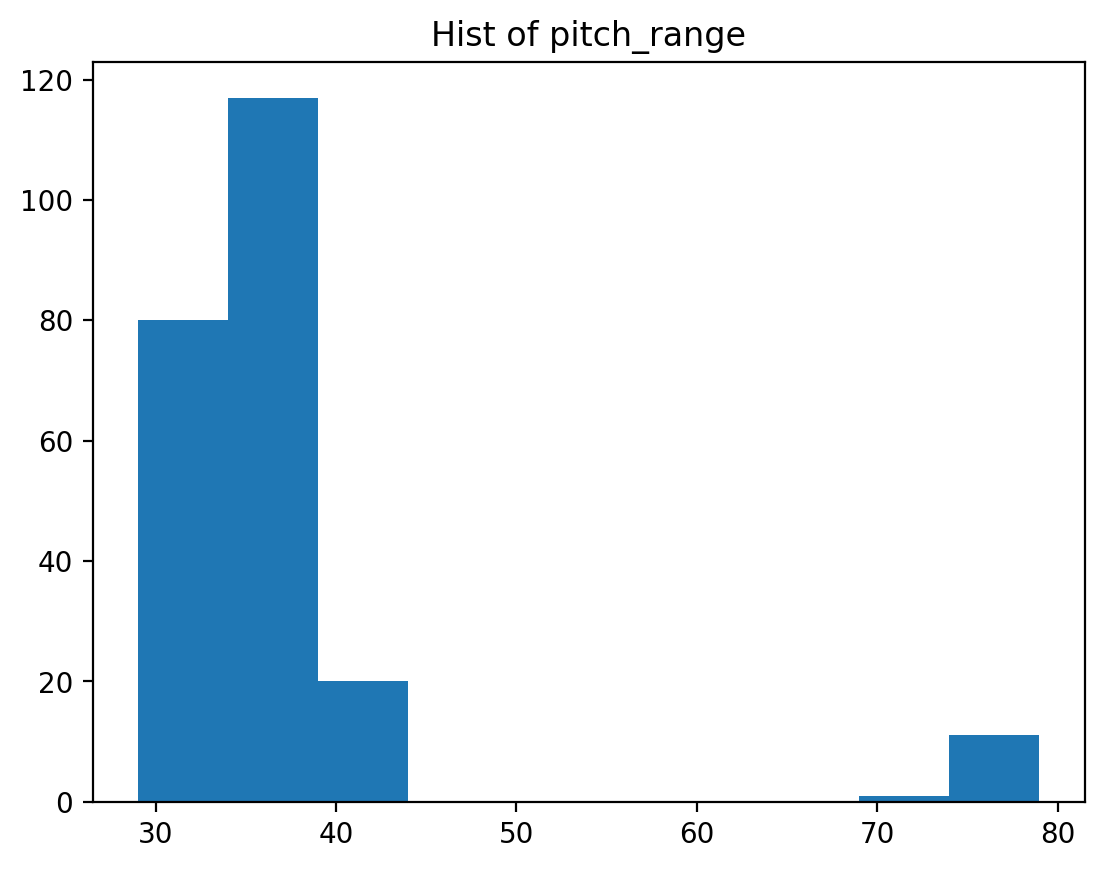

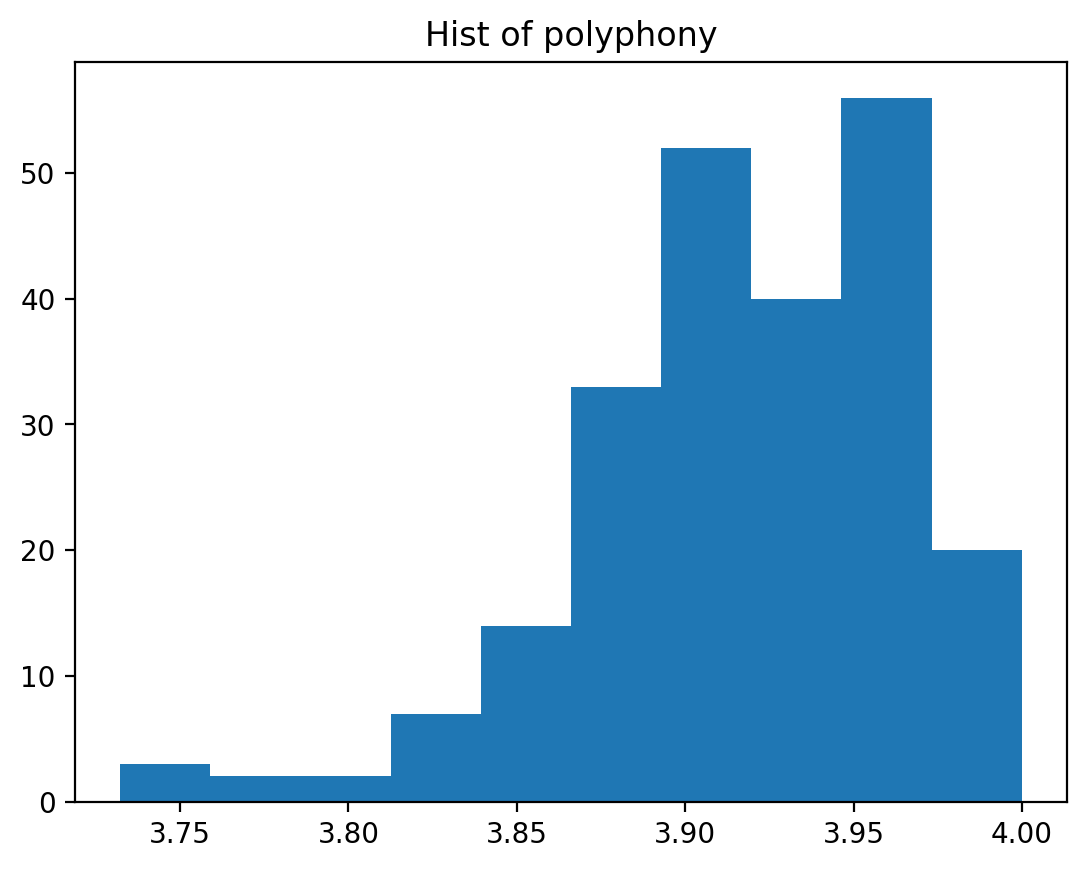

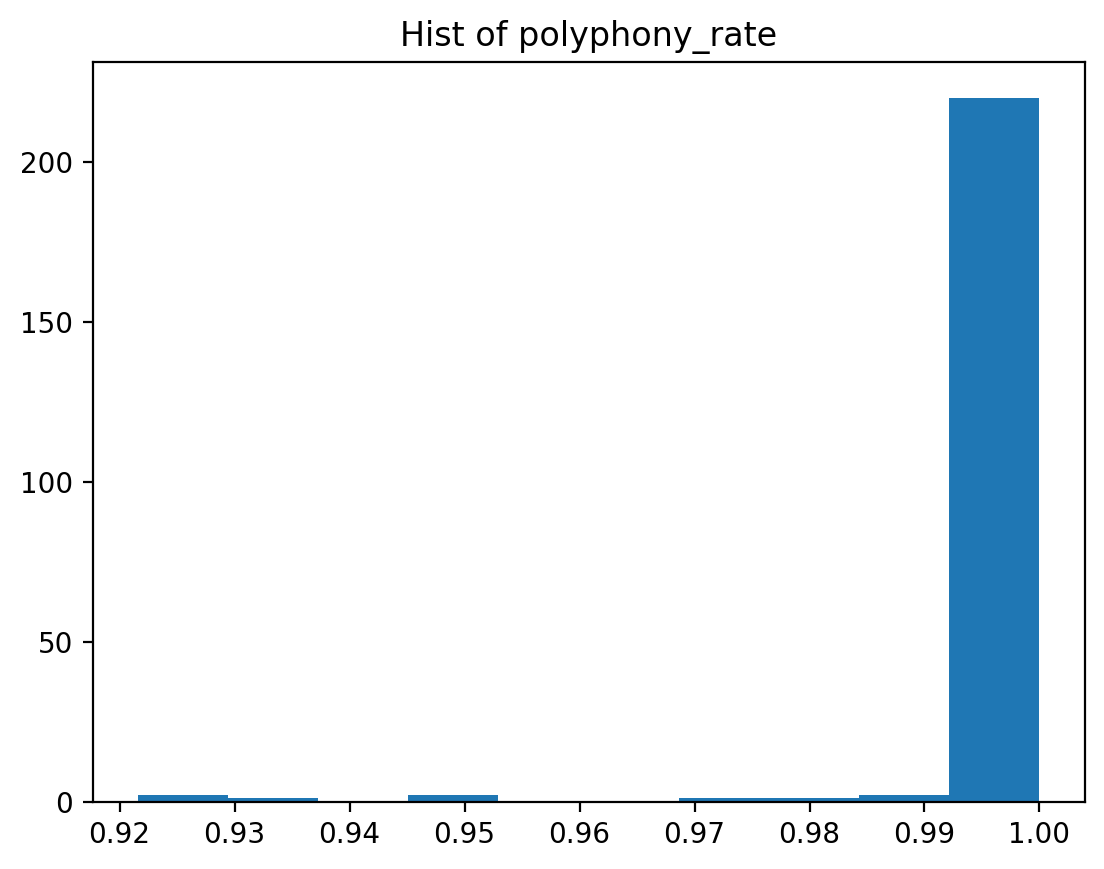

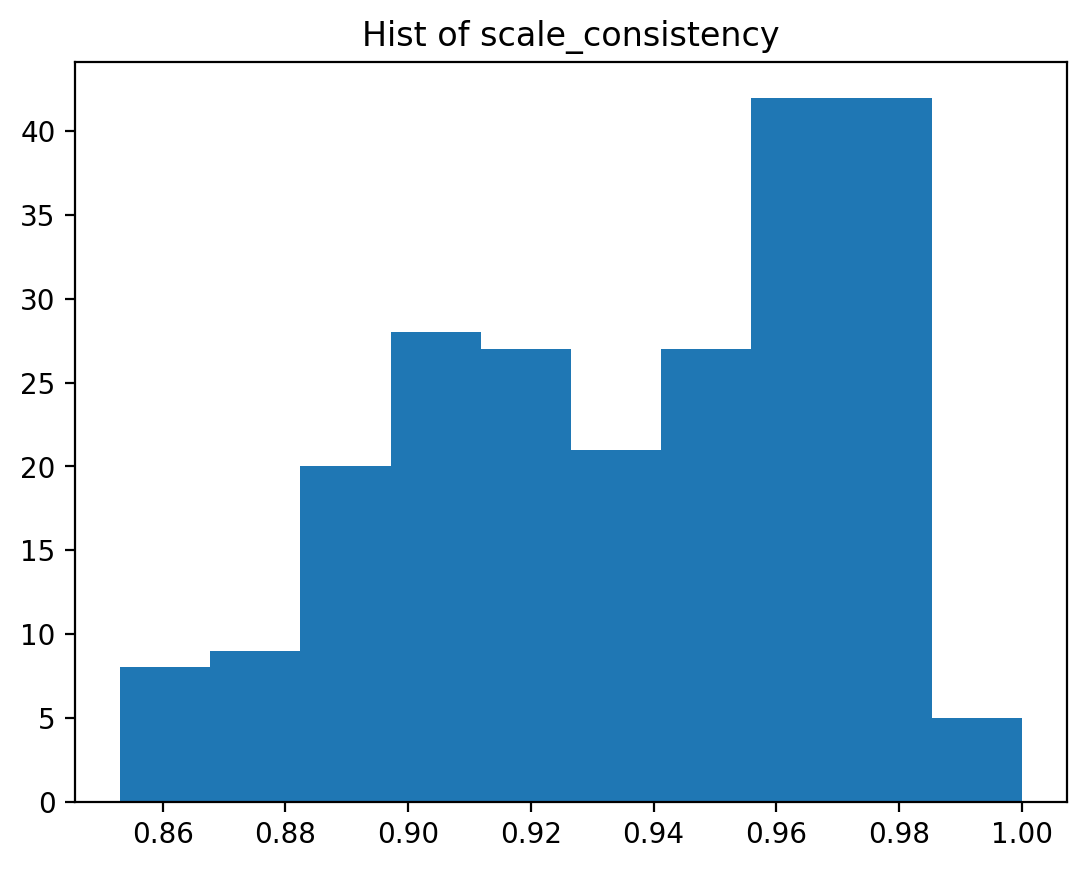

In [ ]:
bach_training_metrics.plot_attr()

In [ ]:
bach_training_metrics.print_p()
print("\n\n")
bach_training_metrics.print_hyp_test(bach_testing_metrics,alpha=1e-19)
print("\n\n")
bach_training_metrics.print_hyp_test(bach_validation_metrics,alpha=1e-19)

n_pitch_classes_used : 2.2109425401595217e-11
n_pitches_used       : 1.7766738892532885e-05
pitch_class_entropy  : 0.1965402513742447
pitch_entropy        : 0.2615518867969513
pitch_range          : 4.855402386818461e-25
polyphony            : 7.56541282953549e-08
polyphony_rate       : 1.9476545846232008e-30
scale_consistency    : 7.680856128899904e-07



n_pitch_classes_used : 1
n_pitches_used       : 1
pitch_class_entropy  : 1
pitch_entropy        : 1
pitch_range          : -1
polyphony            : 1
polyphony_rate       : -1
scale_consistency    : 1



n_pitch_classes_used : 1
n_pitches_used       : 1
pitch_class_entropy  : 1
pitch_entropy        : 1
pitch_range          : -1
polyphony            : 1
polyphony_rate       : -1
scale_consistency    : 1


# **Calculating for Pianoroll**

## Setup

In [ ]:
!pip install pretty_midi -q
!pip install mir_eval -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Imports
import librosa
import pretty_midi
import numpy as np
import pandas as pd 

# For plotting
import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
# For putting audio in the notebook
import IPython.display

In [ ]:
# Get list of MIDI data
midi_files = pd.read_csv('/content/drive/Shareddrives/EC523_Project/maestro-v3.0.0/maestro-v3.0.0.csv')
midi_files = midi_files.values.tolist()

## Characterization

In [ ]:
# Create metrics object
training_metrics = Metrics()

# Ingest and characterize all training data
PATH_STUB = '/content/drive/Shareddrives/EC523_Project/maestro-v3.0.0/'
fs = 10 # Sample frequency
for i in range(len(midi_files)) :
  # column C/2 is the split, E/4 is the MIDI filename
  if midi_files[i][2] == 'train' :
    pm = pretty_midi.PrettyMIDI(PATH_STUB + midi_files[i][4])
    # estimate time-steps per quarter-note
    tempo = pm.estimate_tempo()
    bps = tempo/60.0 # beats per second
    res = round(fs/bps) if round(fs/bps) > 0 else 1 # samples per beat
    pianoroll = pm.get_piano_roll(fs=fs)

    # Get metrics
    training_metrics.append(getMetricsPianoroll(pianoroll))

  #Print progress
  if (i % 100) == 0 :
    print(f"{i} of {len(midi_files)}")

0 of 1276
100 of 1276
200 of 1276
300 of 1276
400 of 1276
500 of 1276
600 of 1276
700 of 1276
800 of 1276
900 of 1276
1000 of 1276
1100 of 1276
1200 of 1276


In [ ]:
# Create metrics object
validation_metrics = Metrics()

# Ingest and characterize all training data
PATH_STUB = '/content/drive/Shareddrives/EC523_Project/maestro-v3.0.0/'
fs = 10 # Sample frequency
for i in range(len(midi_files)) :
  # column C/2 is the split, E/4 is the MIDI filename
  if midi_files[i][2] == 'validation' :
    pm = pretty_midi.PrettyMIDI(PATH_STUB + midi_files[i][4])
    # estimate time-steps per quarter-note
    tempo = pm.estimate_tempo()
    bps = tempo/60.0 # beats per second
    res = round(fs/bps) if round(fs/bps) > 0 else 1 # samples per beat
    pianoroll = pm.get_piano_roll(fs=fs)

    # Get metrics
    validation_metrics.append(getMetricsPianoroll(pianoroll))
    
  #Print progress
  if (i % 100) == 0 :
    print(f"{i} of {len(midi_files)}")

0 of 1276
100 of 1276
200 of 1276
300 of 1276
400 of 1276
500 of 1276
600 of 1276
700 of 1276
800 of 1276
900 of 1276
1000 of 1276
1100 of 1276
1200 of 1276


In [ ]:
# Create metrics object
testing_metrics = Metrics()

# Ingest and characterize all training data
PATH_STUB = '/content/drive/Shareddrives/EC523_Project/maestro-v3.0.0/'
fs = 10 # Sample frequency
for i in range(len(midi_files)) :
  # column C/2 is the split, E/4 is the MIDI filename
  if midi_files[i][2] == 'test' :
    pm = pretty_midi.PrettyMIDI(PATH_STUB + midi_files[i][4])
    # estimate time-steps per quarter-note
    tempo = pm.estimate_tempo()
    bps = tempo/60.0 # beats per second
    res = round(fs/bps) if round(fs/bps) > 0 else 1 # samples per beat
    pianoroll = pm.get_piano_roll(fs=fs)

    # Get metrics
    testing_metrics.append(getMetricsPianoroll(pianoroll))

  #Print progress
  if (i % 100) == 0 :
    print(f"{i} of {len(midi_files)}")

0 of 1276
100 of 1276
200 of 1276
300 of 1276
400 of 1276
500 of 1276
600 of 1276
700 of 1276
800 of 1276
900 of 1276
1000 of 1276
1100 of 1276
1200 of 1276


## Save/Load data

In [ ]:
# Save Data for later
import pickle

def save_object(obj,name="data",path="/content/drive/Shareddrives/EC523_Project/CodeWorkspace/MaestroMetrics/"):
    try:
        f = open((path + name + ".pickle"), "wb")
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)

# save_object(training_metrics, "training_metrics")
save_object(validation_metrics, "validation_metrics")
# save_object(testing_metrics, "testing_metrics")

In [ ]:
# Load Data
import pickle

def load_object(filename, path="/content/drive/Shareddrives/EC523_Project/CodeWorkspace/MaestroMetrics/"):
    try:
        with open(path + filename+".pickle", "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)

piano_training_metrics = load_object("training_metrics")
piano_validation_metrics = load_object("validation_metrics")
piano_testing_metrics = load_object("testing_metrics")

## Evaluate Data

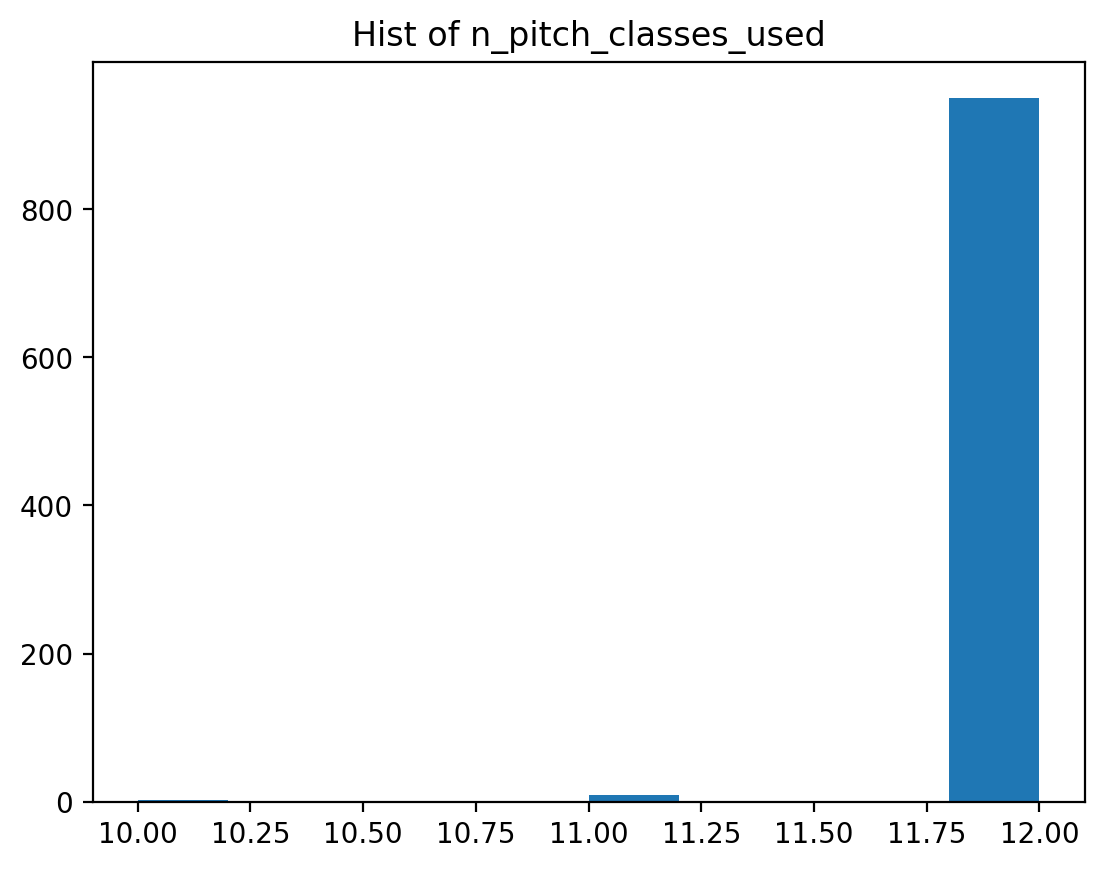

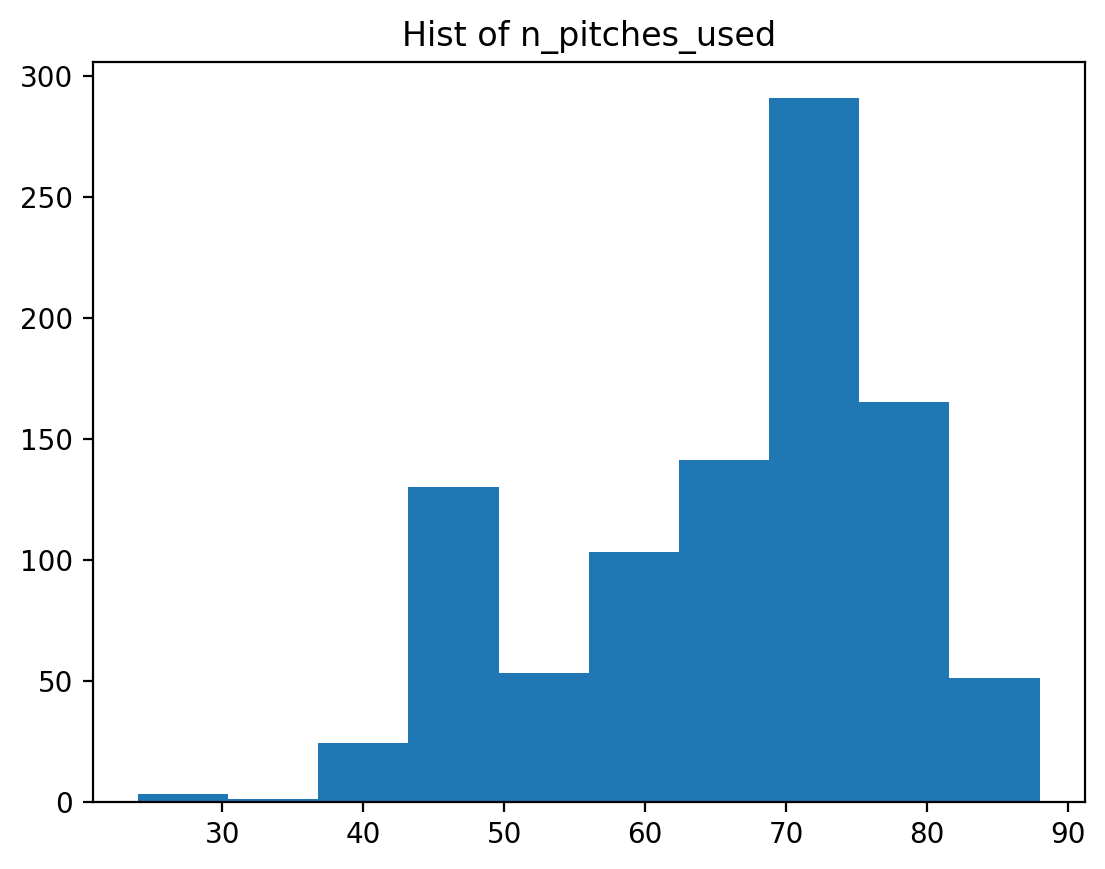

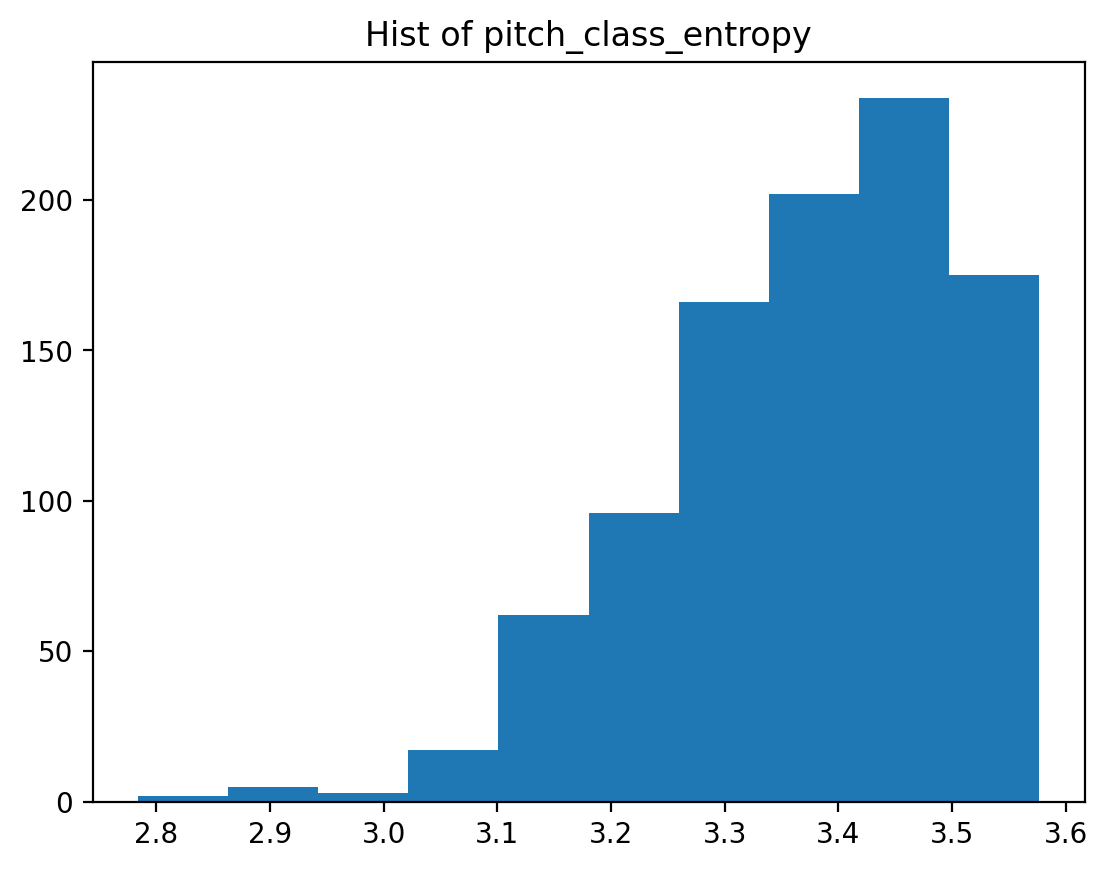

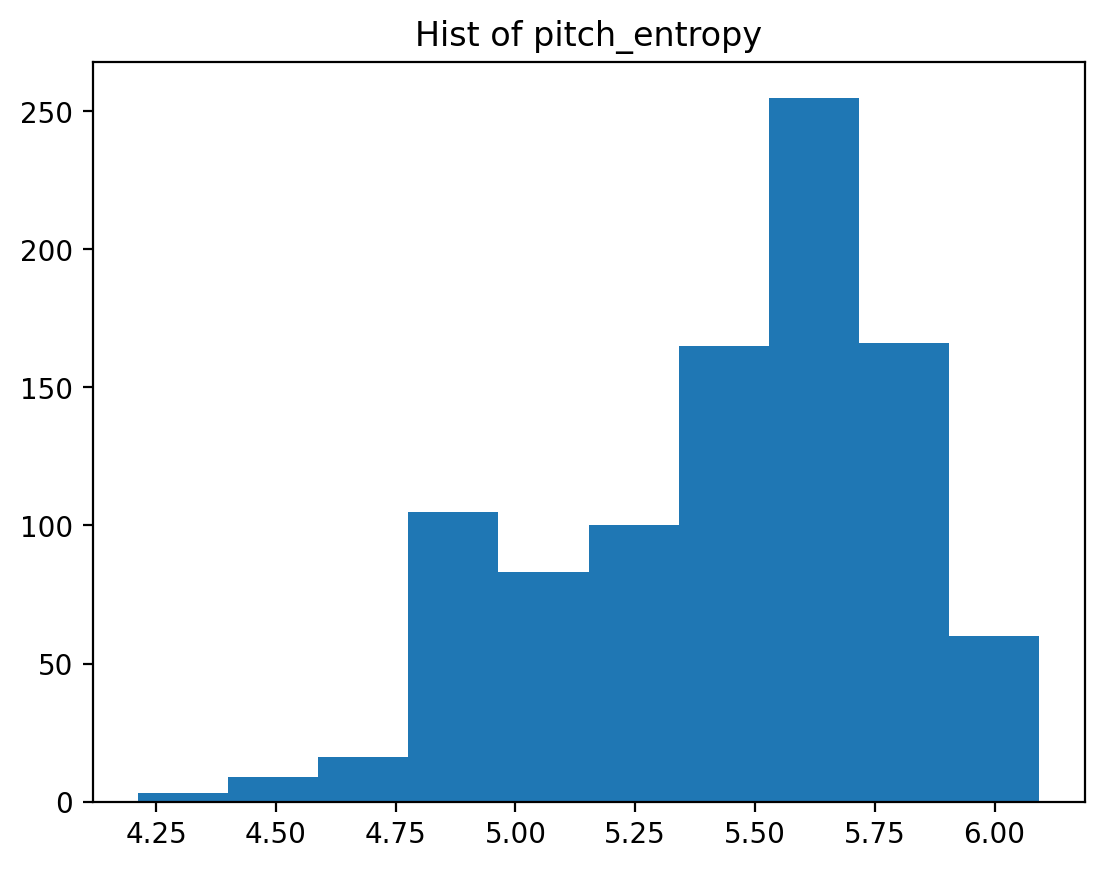

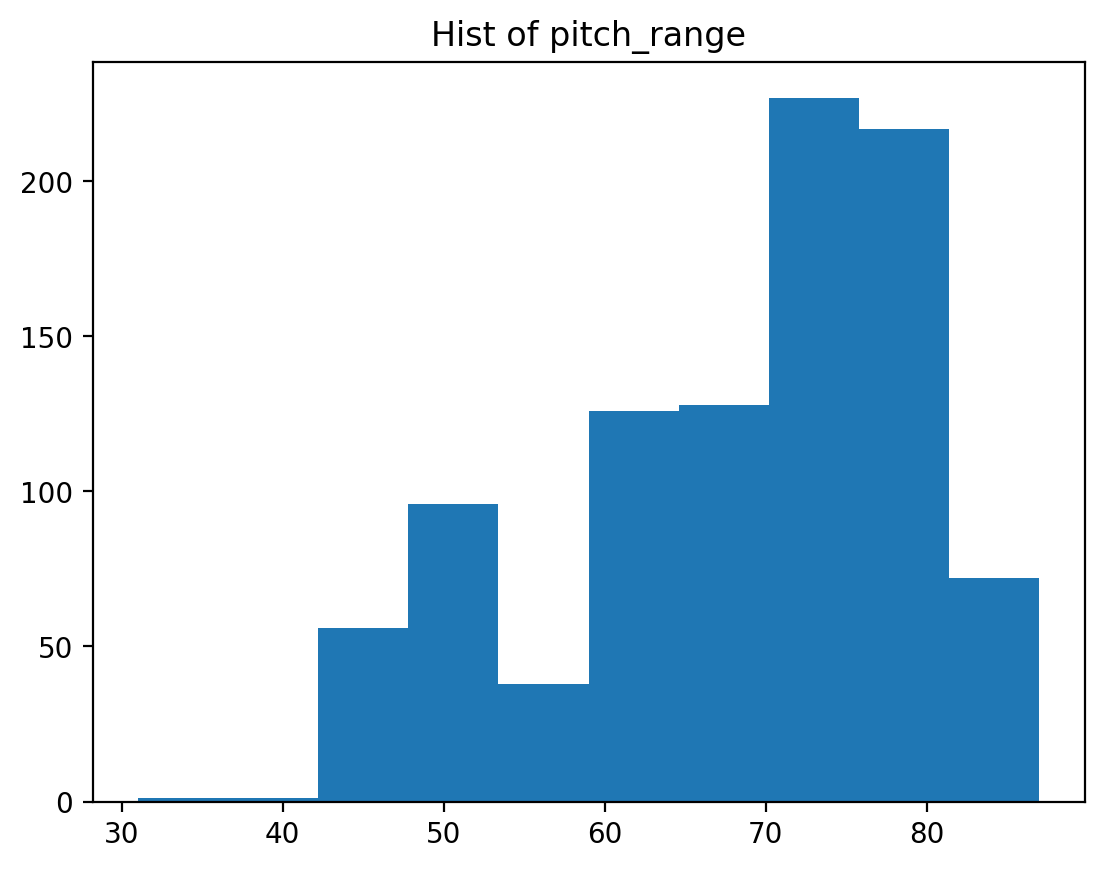

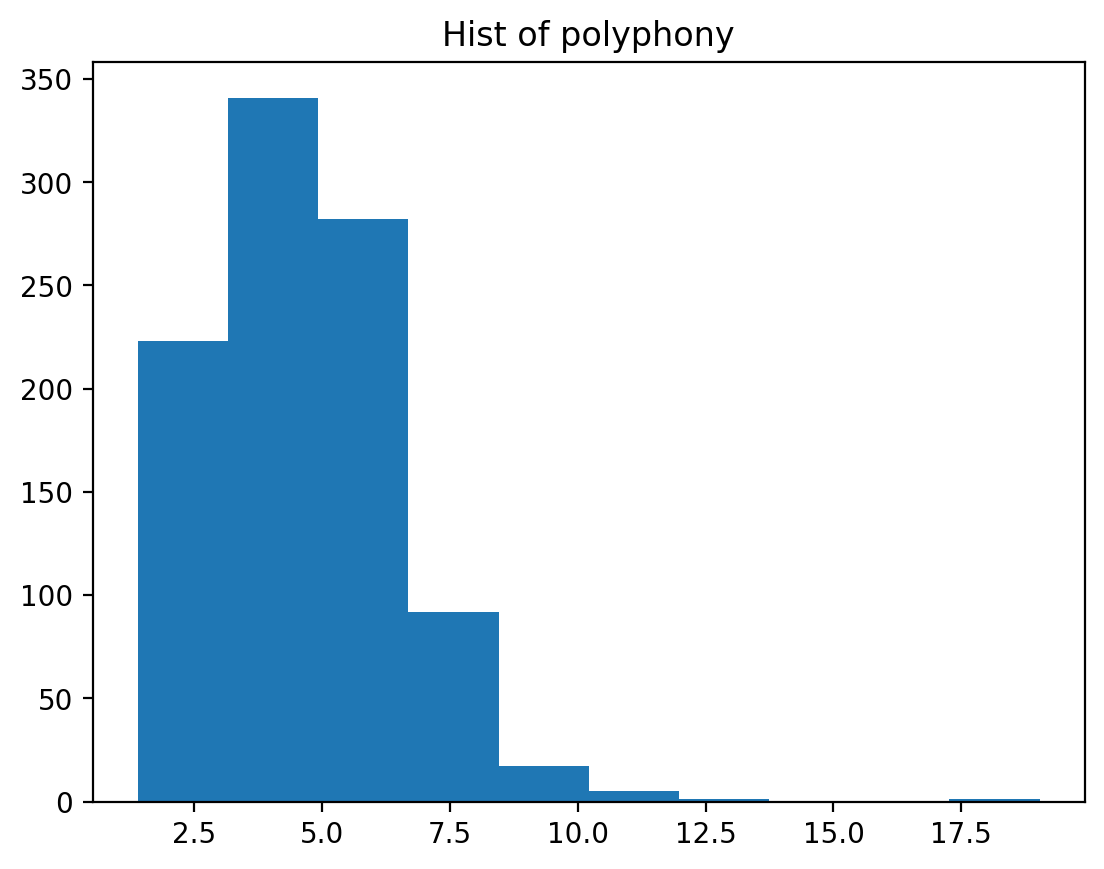

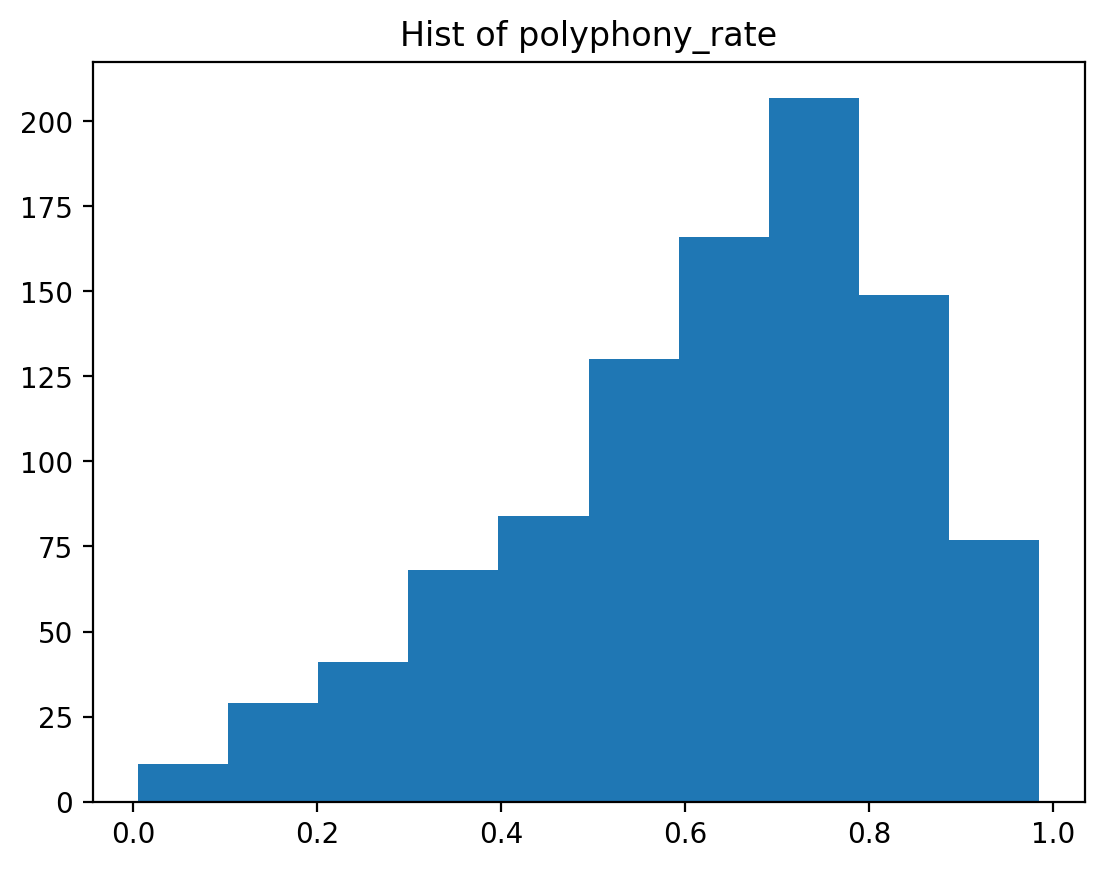

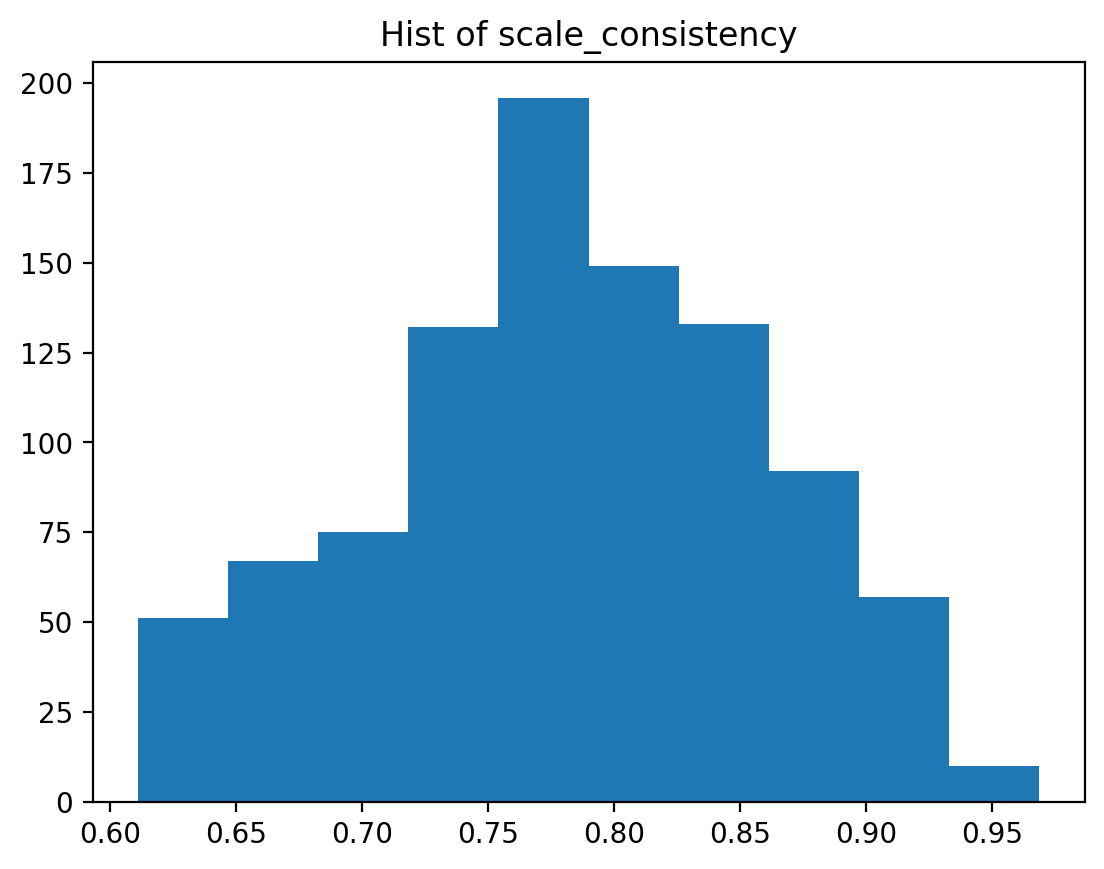

In [ ]:
training_metrics.plot_attr()

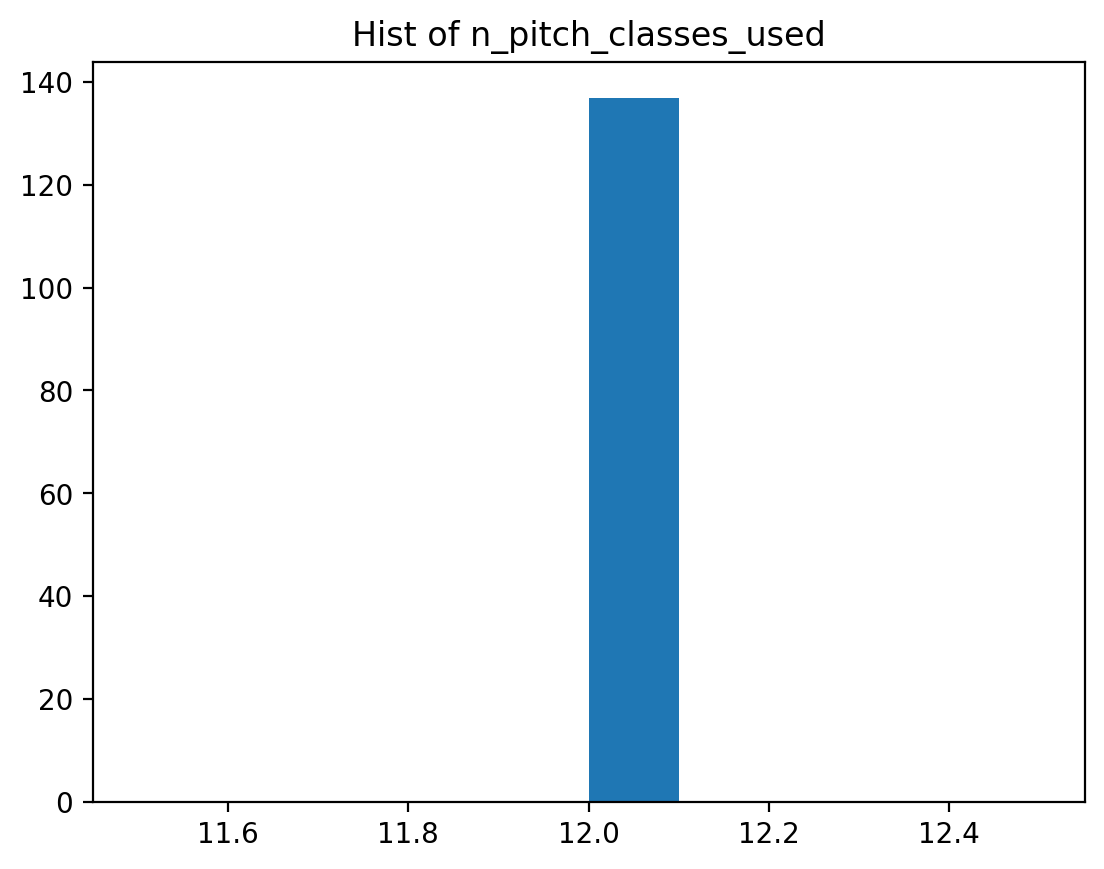

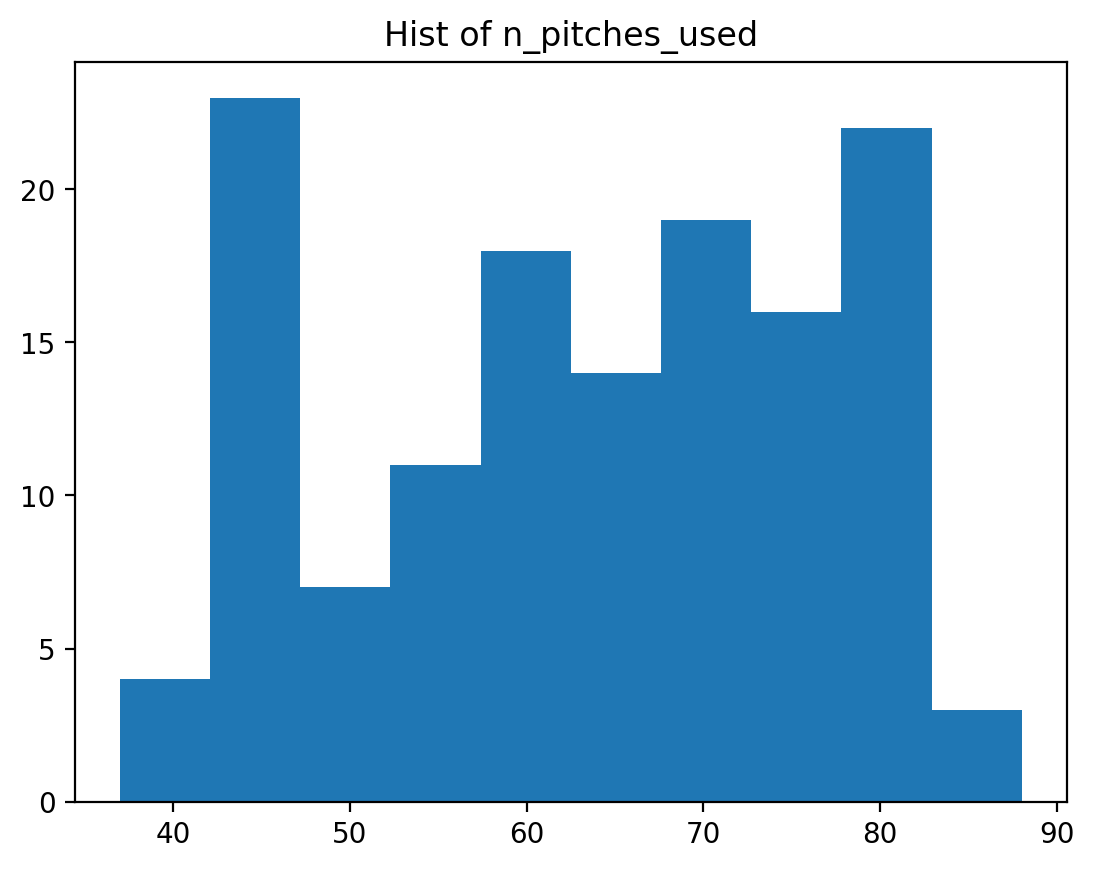

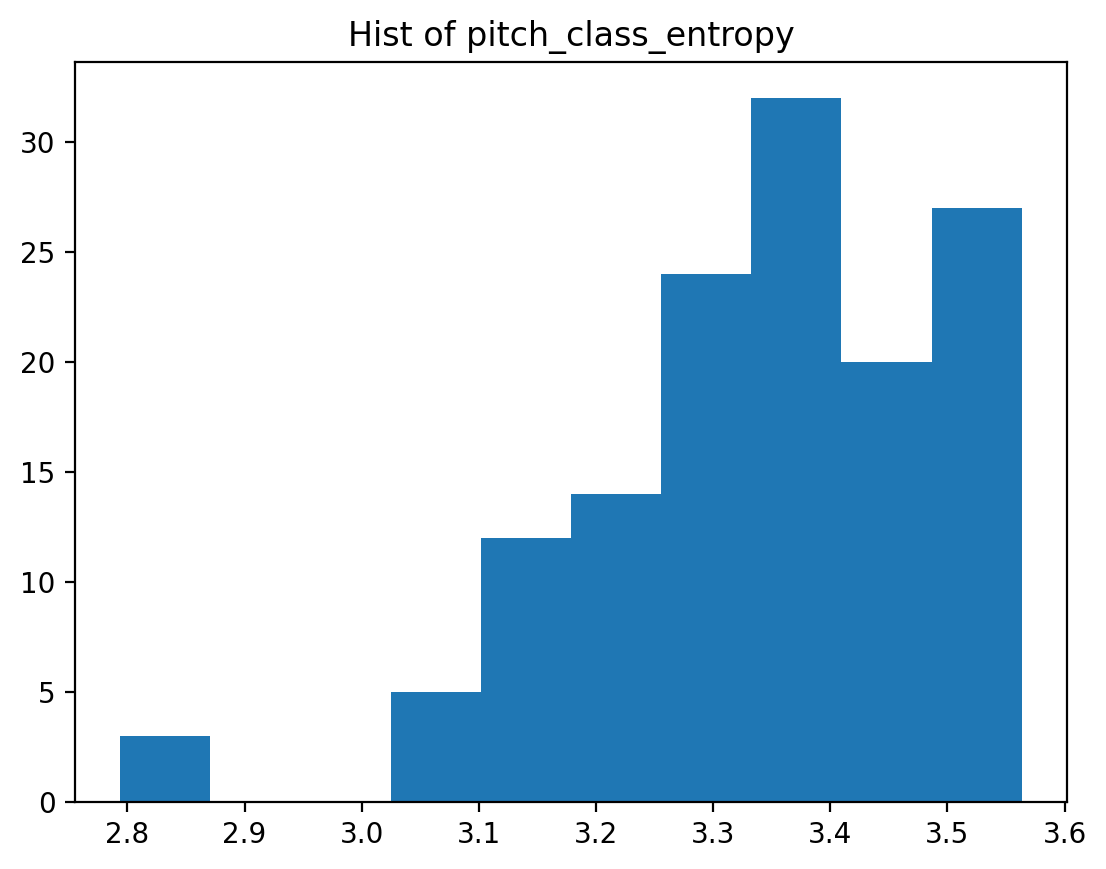

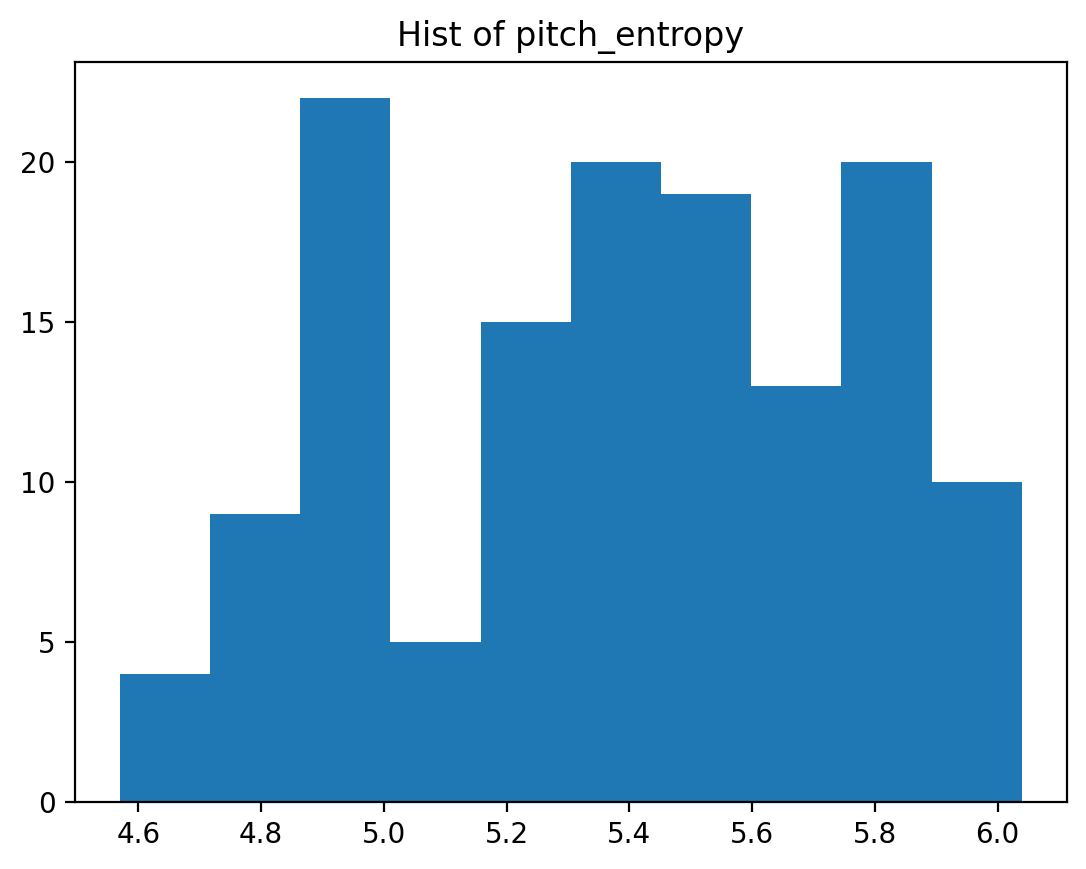

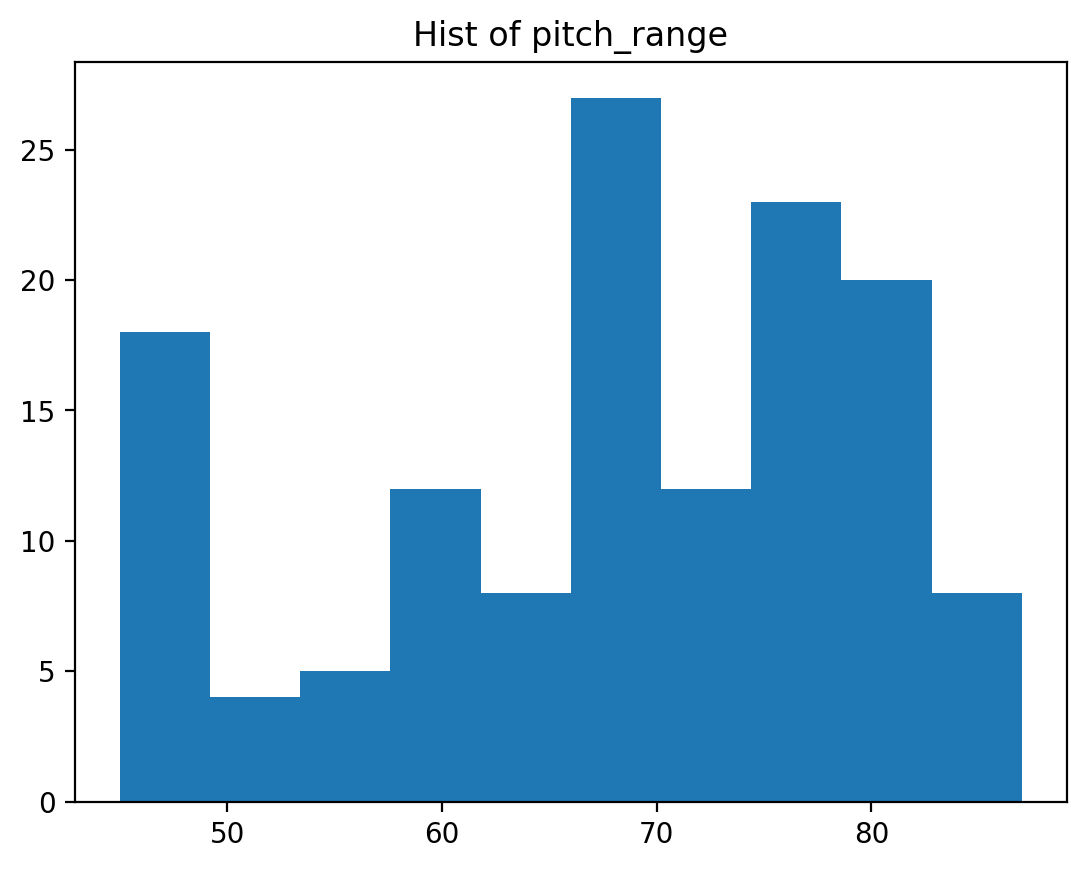

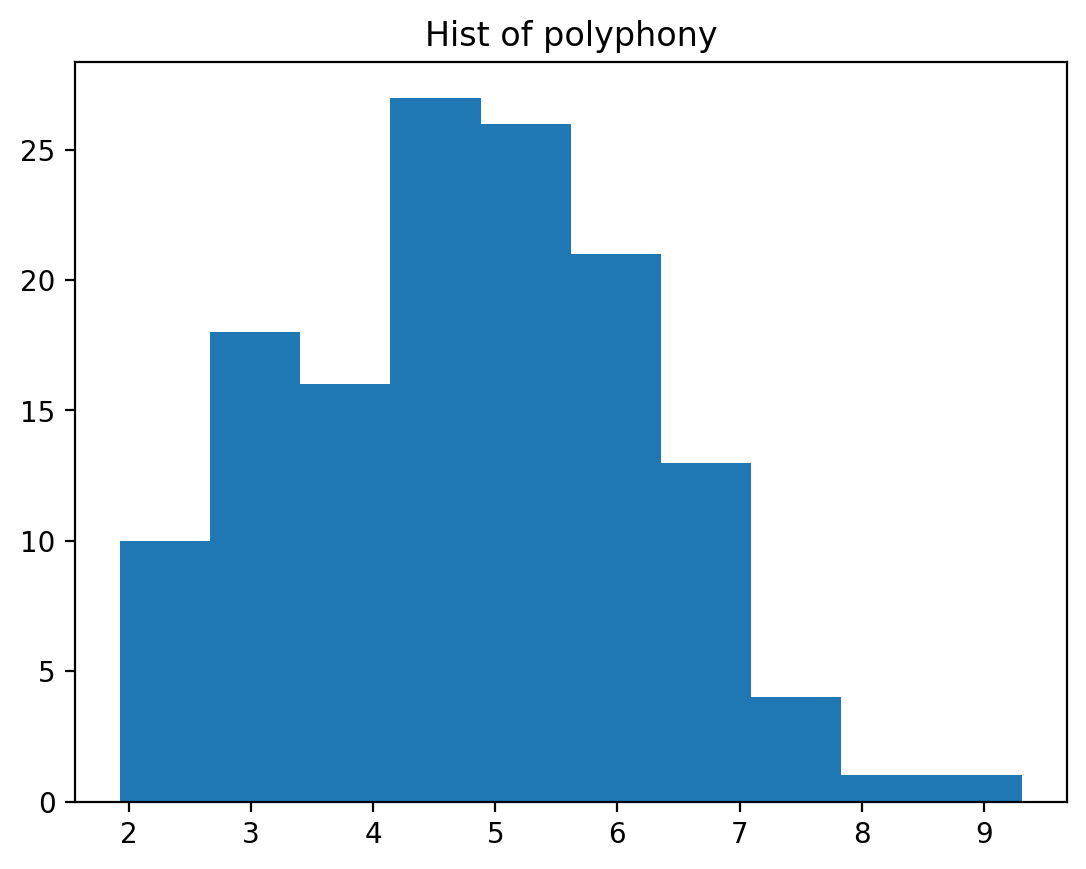

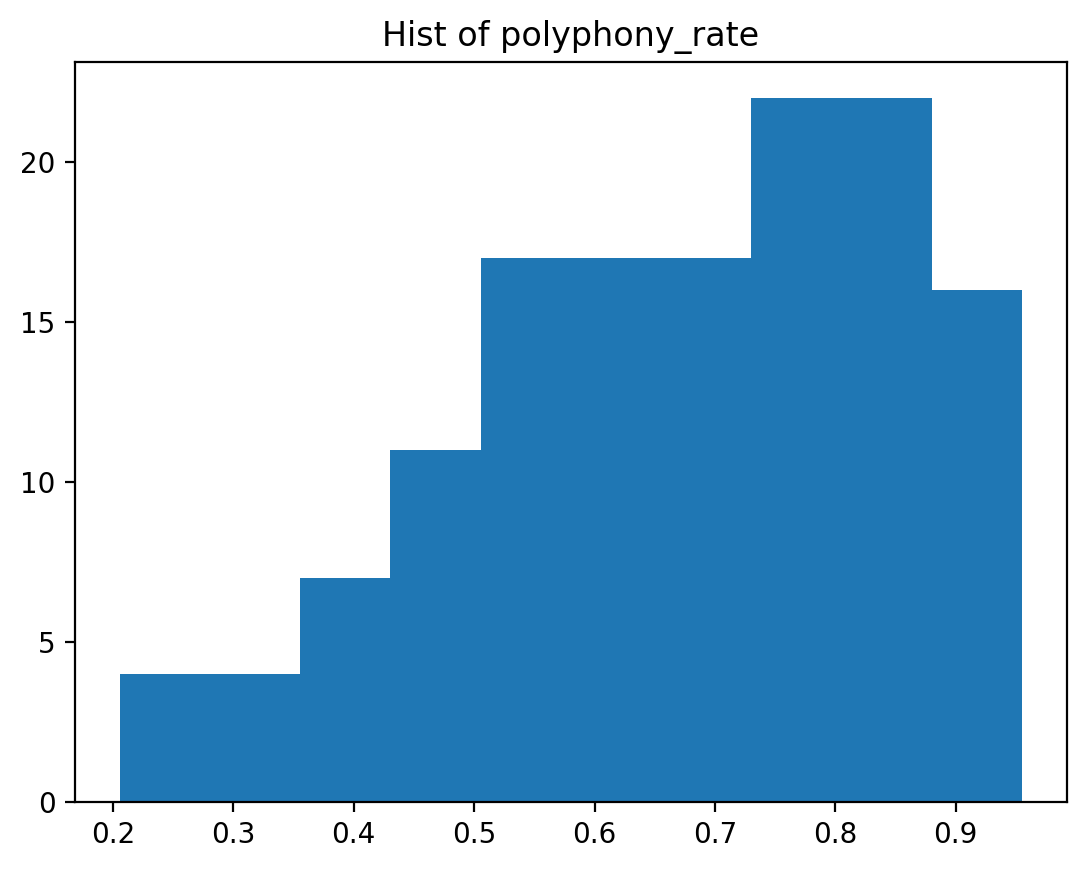

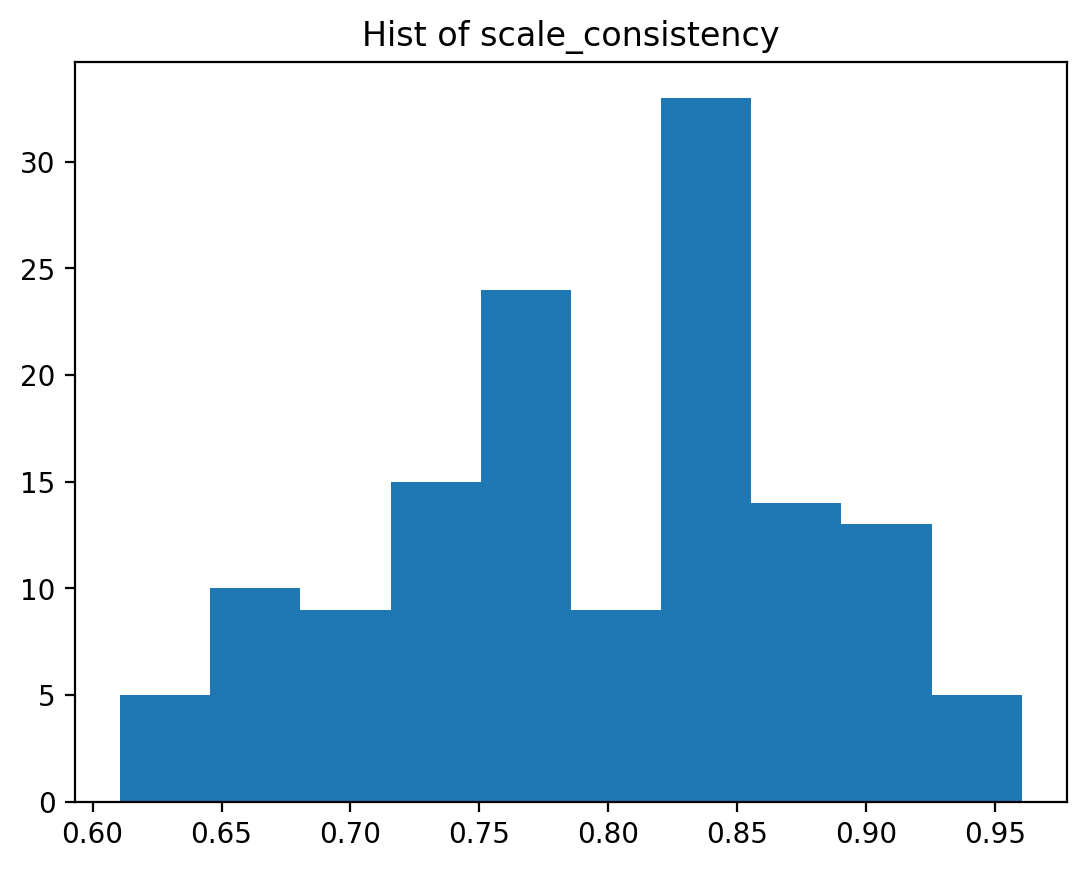

In [ ]:
validation_metrics.plot_attr()

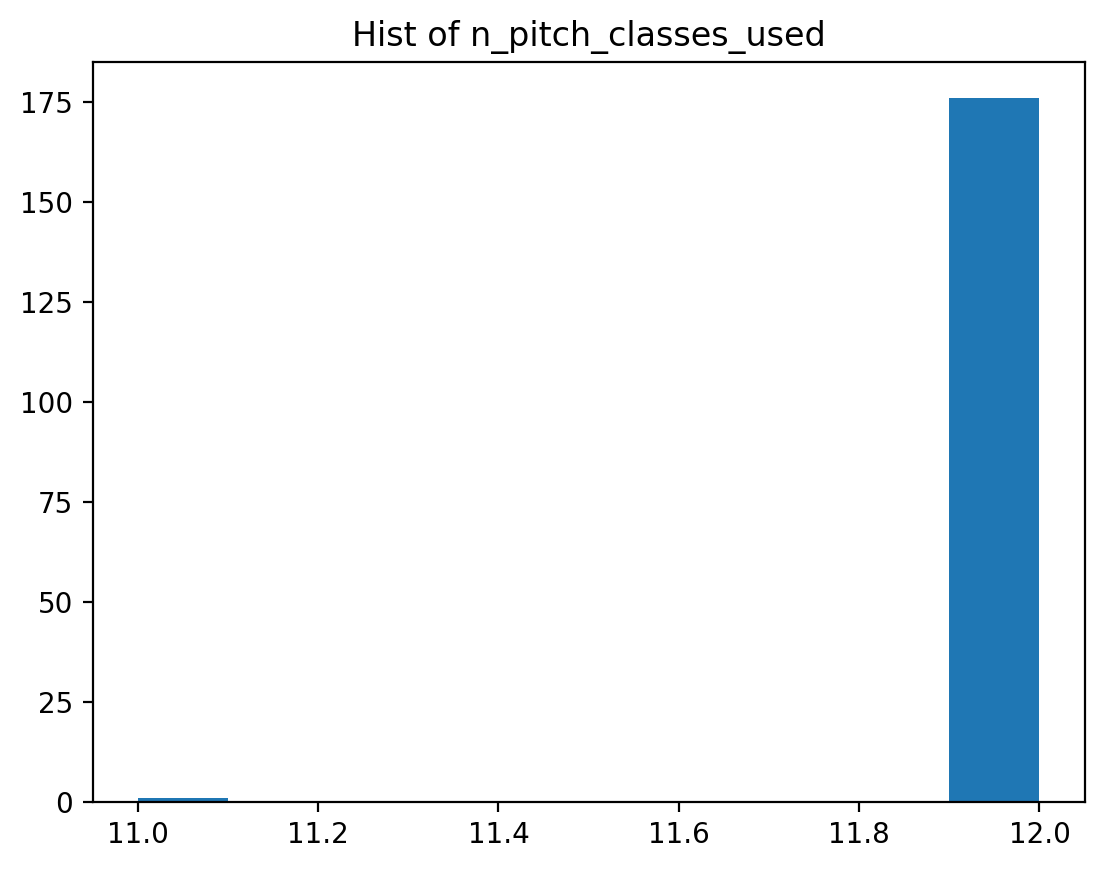

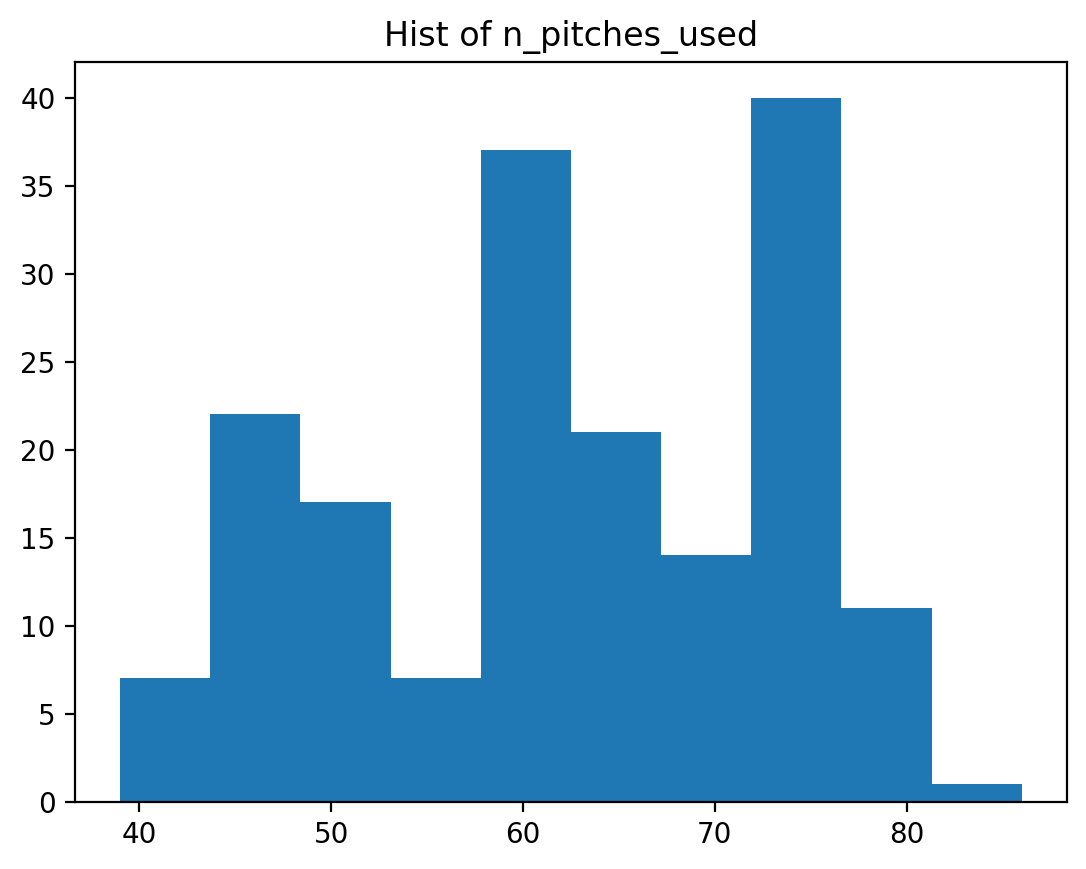

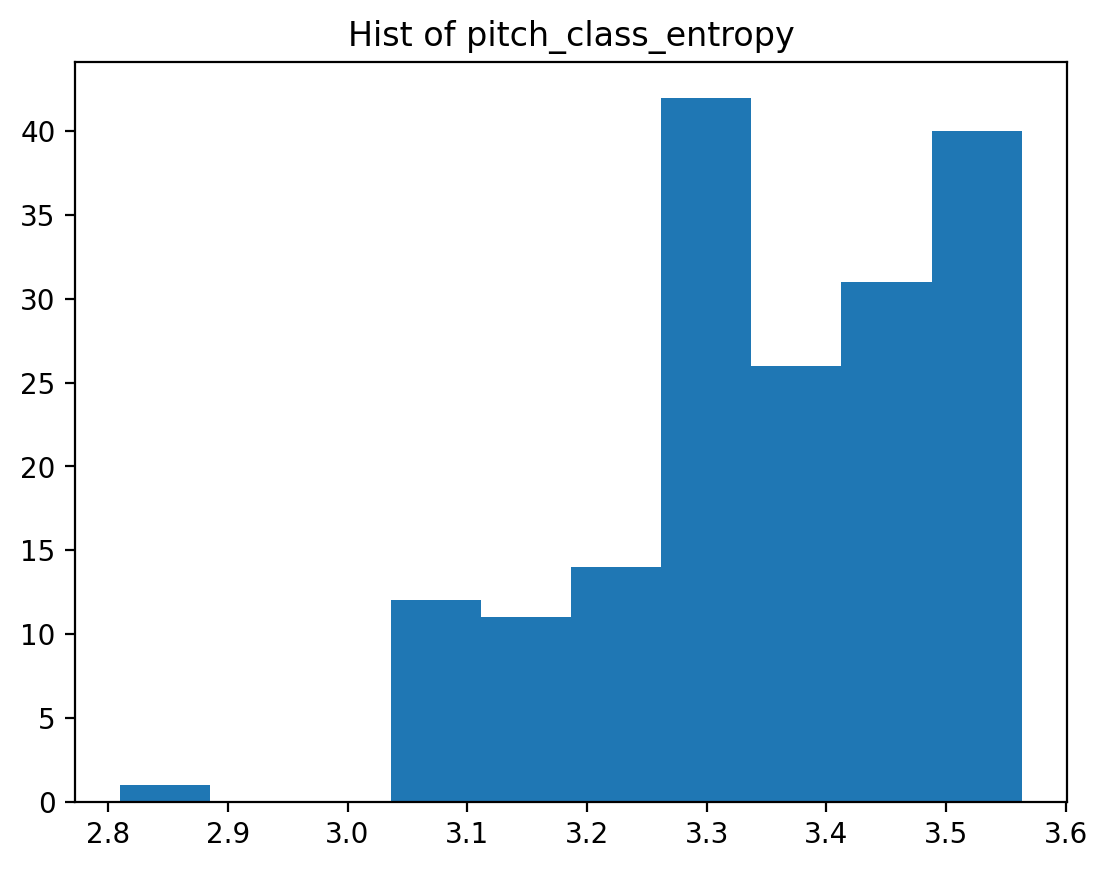

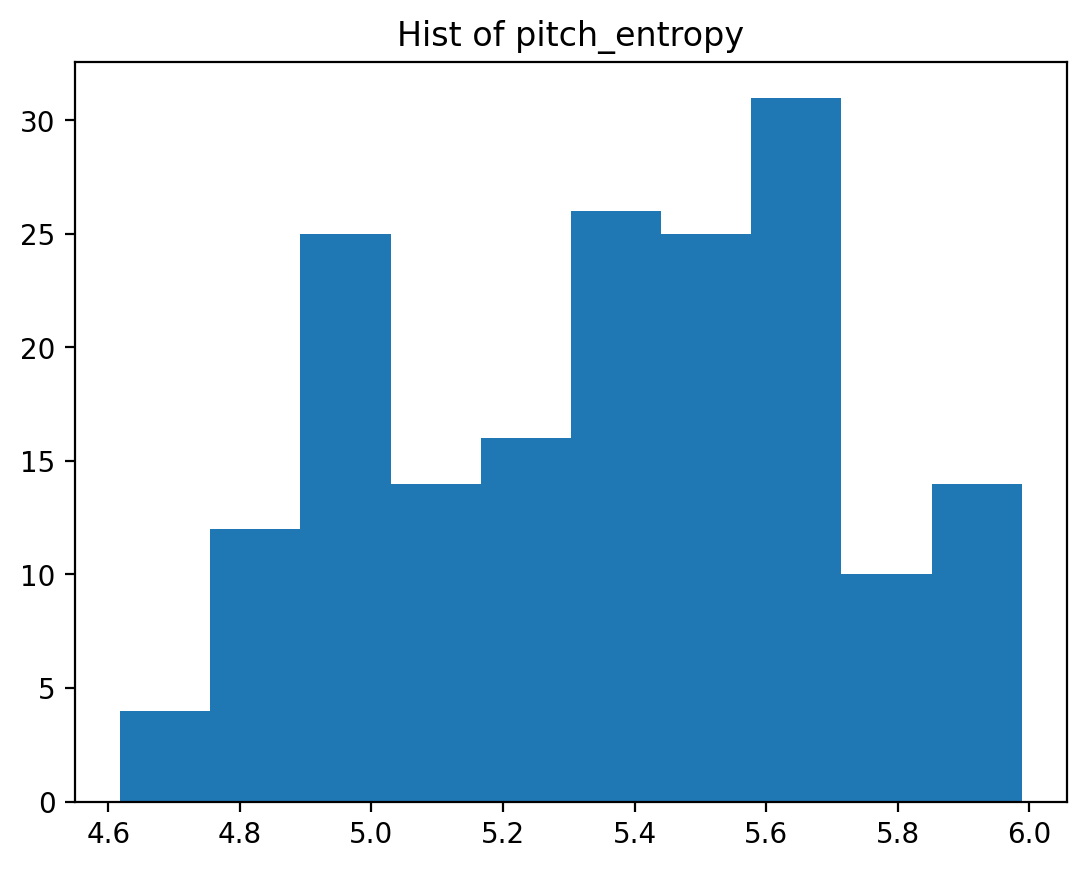

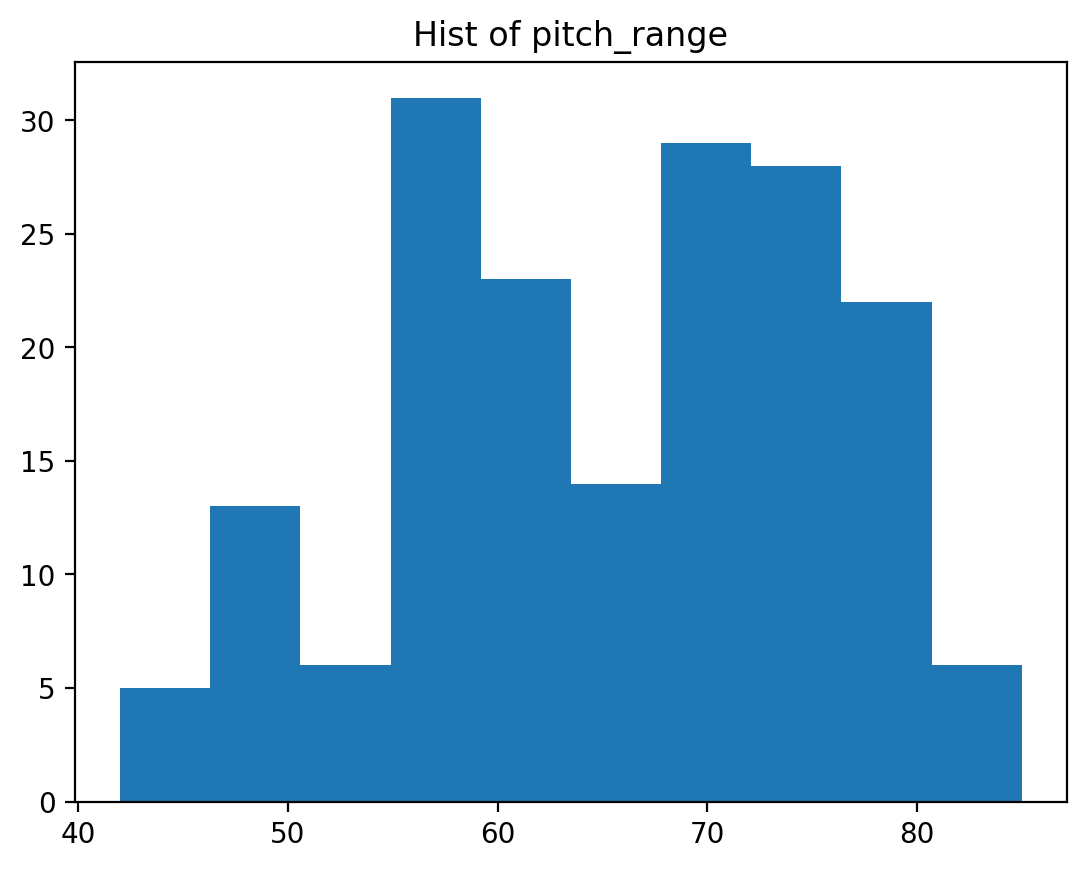

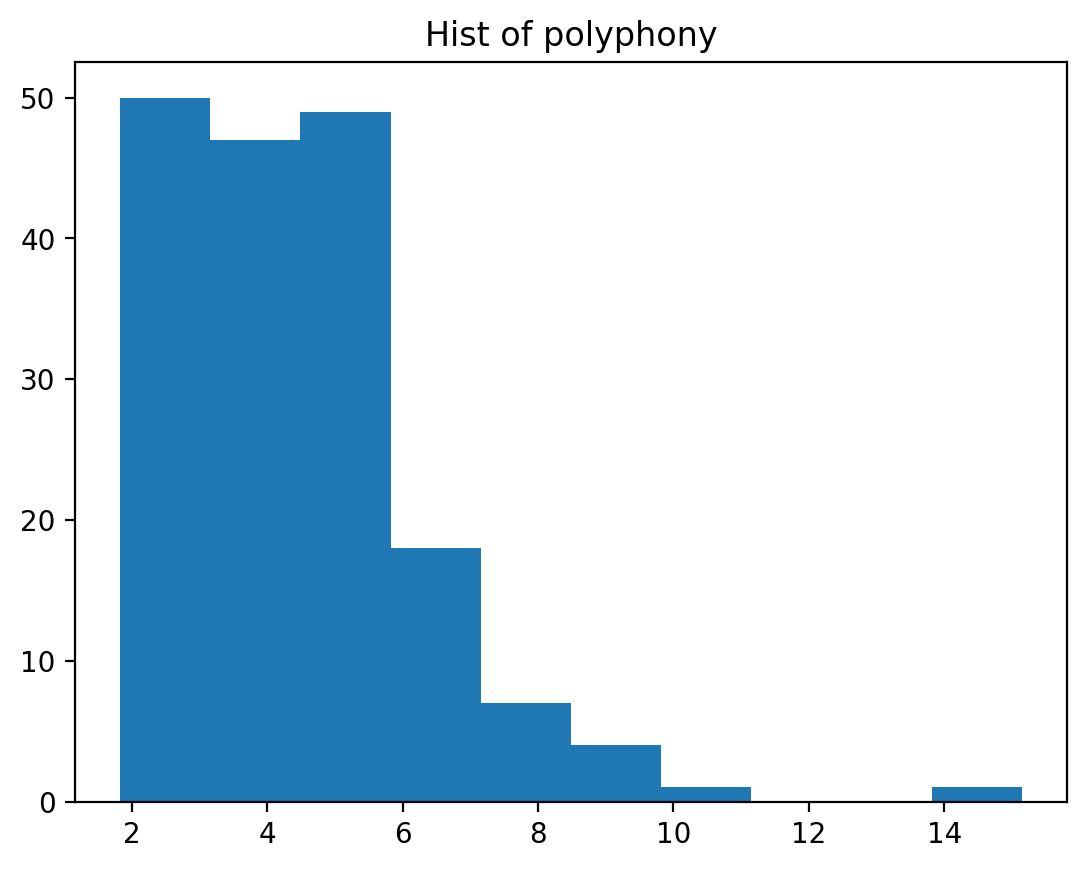

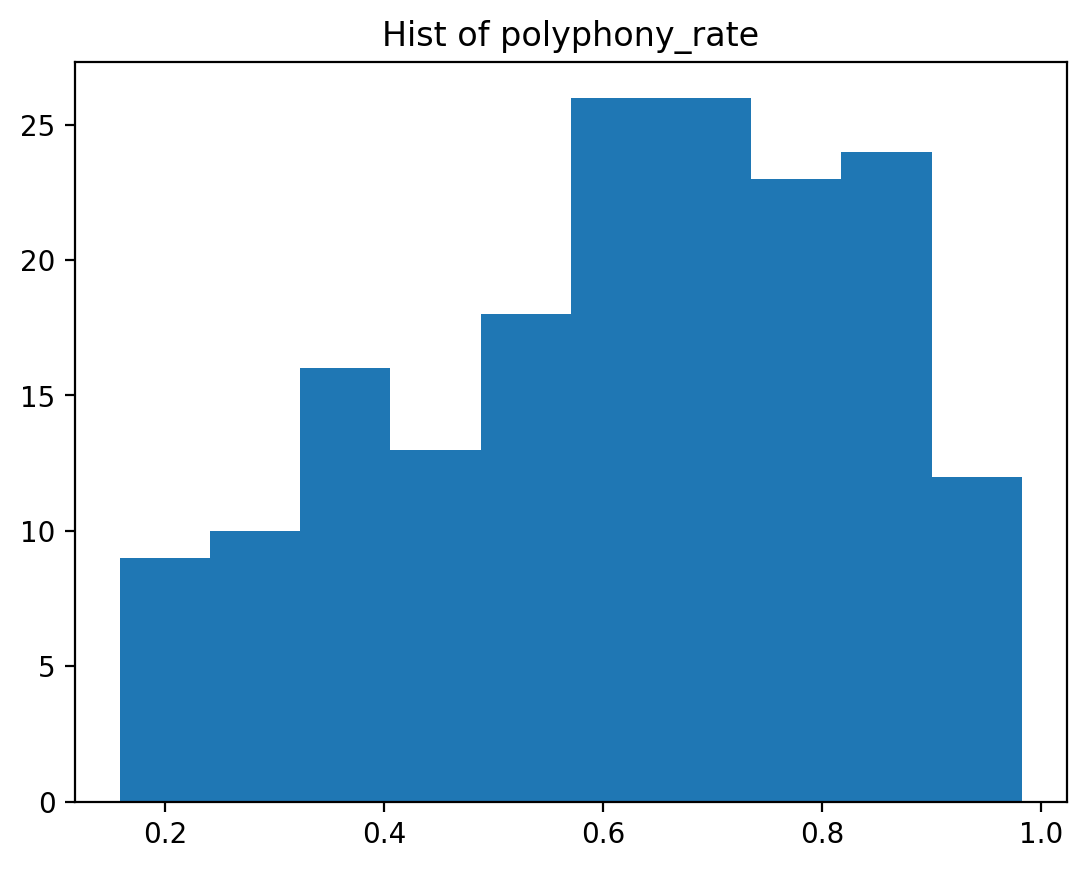

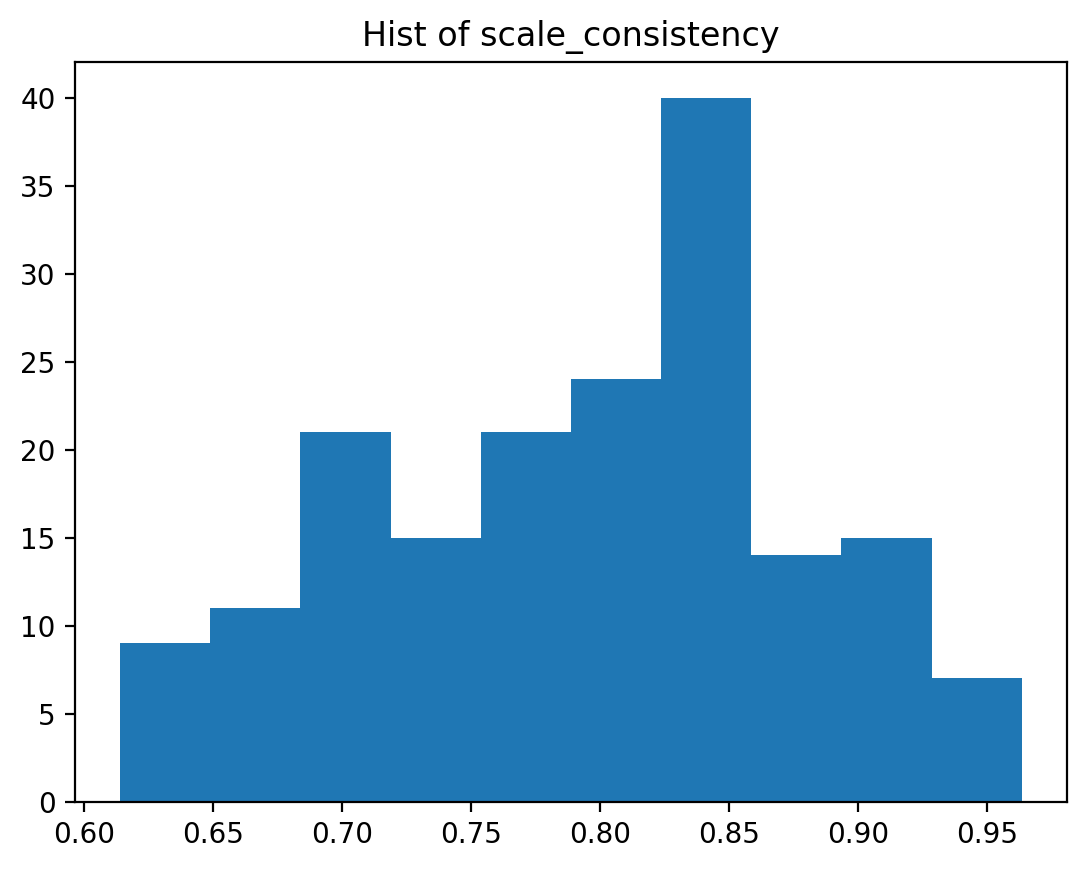

In [ ]:
testing_metrics.plot_attr()

In [ ]:
print("Validation Metrics:")
piano_training_metrics.print_hyp_test(piano_validation_metrics, alpha=0, ci=1)
print("\n\nTesting Metrics:")
piano_training_metrics.print_hyp_test(piano_testing_metrics, alpha=0, ci=1)

Validation Metrics:
n_pitch_classes_used : -1
n_pitches_used       : 0
pitch_class_entropy  : 0
pitch_entropy        : 0
pitch_range          : 0
polyphony            : 0
polyphony_rate       : 0
scale_consistency    : 0


Testing Metrics:
n_pitch_classes_used : -1
n_pitches_used       : 0
pitch_class_entropy  : 0
pitch_entropy        : 0
pitch_range          : 0
polyphony            : 0
polyphony_rate       : 0
scale_consistency    : 0


# Evaluating Generated Music


## Chorale

In [49]:
# Load Training Data
import pickle

def load_object(filename, path="/content/drive/Shareddrives/EC523_Project/CodeWorkspace/BachMetrics/"):
    try:
        with open(path + filename+".pickle", "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)

bach_training_metrics = load_object("training_metrics")

num_tracks = 62
num_fields = 8
PATH_STUB = '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/WaveNet_30/'

col_gen_metrics = Metrics()
ind_gen_results = np.zeros([num_tracks, num_fields])

for i in range(num_tracks) :
  note_list = pd.read_csv(PATH_STUB+f'{i}.csv')
  note_list = note_list.values.tolist()

  # Ensure is all int
  for j in range(0, len(note_list)):
    for k in range(0, len(note_list[j])):
      note_list[j][k] = int(note_list[j][k])
  
  # Get metrics
  ind_gen_metrics = Metrics()
  ind_gen_metrics.append(getMetricsChords(note_list))
  col_gen_metrics.append(ind_gen_metrics)

  # For all metrics' fields
  j = 0 #temp itr var for cols

  alpha = 1e-19
  ci = 0.05
  for attr in dir(Metrics()) :
      if not callable(getattr(Metrics(), attr)) and not attr.startswith("__") :
        # if p_score is LEQ than specified alpha, not normal, ignore result
        if ((getattr(bach_training_metrics,attr).p_score()<=alpha and getattr(bach_training_metrics,attr).override != 1) or getattr(bach_training_metrics,attr).override == -1):
          ind_gen_results[i][j]=-1
        else :
          # Calculate z_score = (x_bar - mu)/(sigma / sqrt(n))
          z_score = abs(getattr(ind_gen_metrics,attr).mean()-getattr(bach_training_metrics,attr).mean())/(getattr(bach_training_metrics,attr).std())
          # Calculate if within probability region
          threshold = abs(stat.norm.ppf(1-(ci/2)))
          ind_gen_results[i][j]= 1 if z_score < threshold else 0

        # print("%-20s : %s" % (attr, str(ind_gen_results[i][j])))
        j = j+1

# Calculate for overall
print("\n\nOverall:")
# maestro_training_metrics.print_hyp_test(col_gen_metrics)

j = 0 #temp itr var for cols
alpha = 1e-19
ci = 0.05
for attr in dir(Metrics()) :
  if not callable(getattr(Metrics(), attr)) and not attr.startswith("__") :
    result = 0
    # if p_score is LEQ than specified alpha, not normal, ignore result
    if ((getattr(bach_training_metrics,attr).p_score()<=alpha and getattr(bach_training_metrics,attr).override != 1) or getattr(bach_training_metrics,attr).override == -1):
      result = -1
    else :
      # Calculate z_score = (x_bar - mu)/(sigma / sqrt(n))
      z_score = abs(getattr(col_gen_metrics,attr).mean()-getattr(bach_training_metrics,attr).mean())/(getattr(bach_training_metrics,attr).std())
      # Calculate if within probability region
      threshold = abs(stat.norm.ppf(1-(ci/2)))
      result = 1 if z_score < threshold else 0

    print("%-20s : %s" % (attr, str(result)))



Overall:
n_pitch_classes_used : 1
n_pitches_used       : 0
pitch_class_entropy  : 0
pitch_entropy        : 0
pitch_range          : -1
polyphony            : 1
polyphony_rate       : -1
scale_consistency    : 0


track 0: 	1/6
track 1: 	1/6
track 2: 	2/6
track 3: 	2/6
track 4: 	1/6
track 5: 	4/6
track 6: 	4/6
track 7: 	4/6
track 8: 	4/6
track 9: 	5/6
track 10: 	4/6
track 11: 	3/6
track 12: 	3/6
track 13: 	2/6
track 14: 	2/6
track 15: 	3/6
track 16: 	1/6
track 17: 	1/6
track 18: 	2/6
track 19: 	2/6
track 20: 	3/6
track 21: 	2/6
track 22: 	1/6
track 23: 	1/6
track 24: 	1/6
track 25: 	1/6
track 26: 	2/6
track 27: 	2/6
track 28: 	2/6
track 29: 	2/6
track 30: 	3/6
track 31: 	2/6
track 32: 	3/6
track 33: 	5/6
track 34: 	3/6
track 35: 	1/6
track 36: 	4/6
track 37: 	4/6
track 38: 	4/6
track 39: 	4/6
track 40: 	5/6
track 41: 	5/6
track 42: 	3/6
track 43: 	2/6
track 44: 	2/6
track 45: 	2/6
track 46: 	2/6
track 47: 	3/6
track 48: 	4/6
track 49: 	5/6
track 50: 	4/6
track 51: 	3/6
track 52: 	3/6
track 53: 	2/6
track 54: 	2/6
track 55: 	2/6
track 56: 	2/6
track 57: 	4/6
track 58: 	4/6
track 59: 	4/6
track 60: 	2/6
track 61: 	3/6
Overall: 	5/62 (2.725806451612903/6)


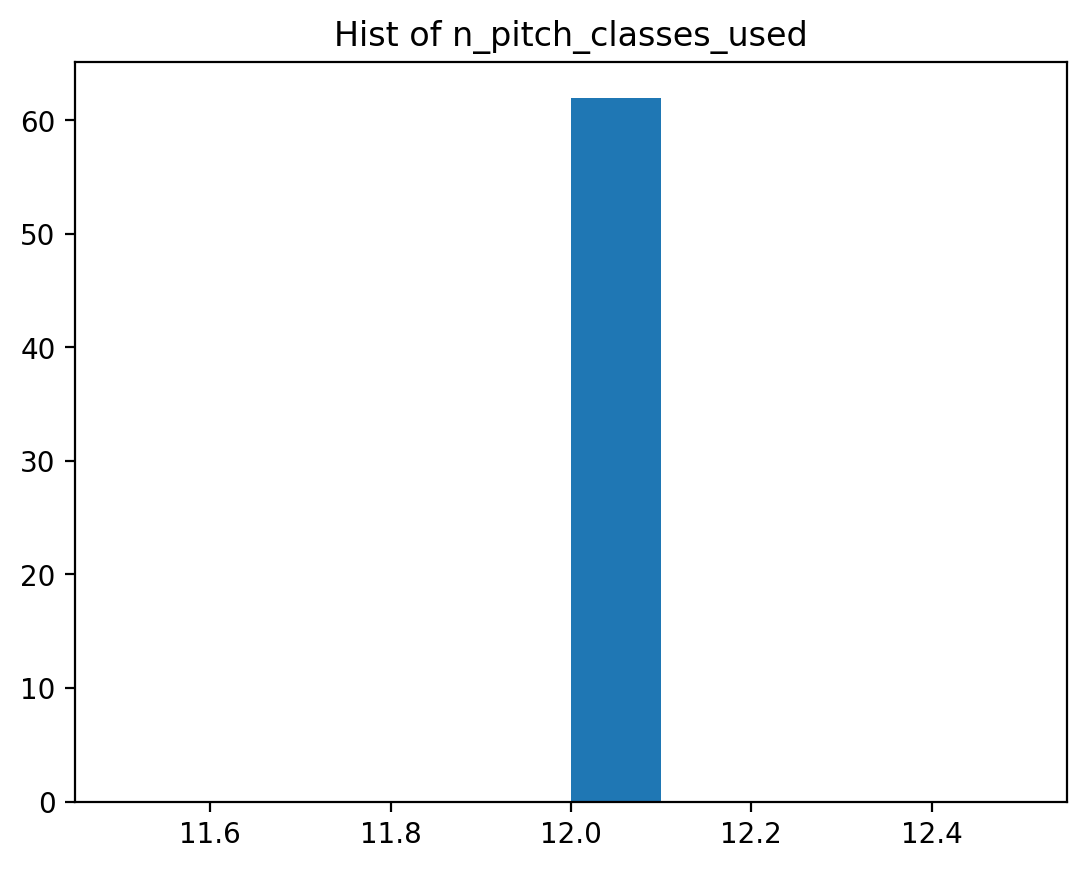

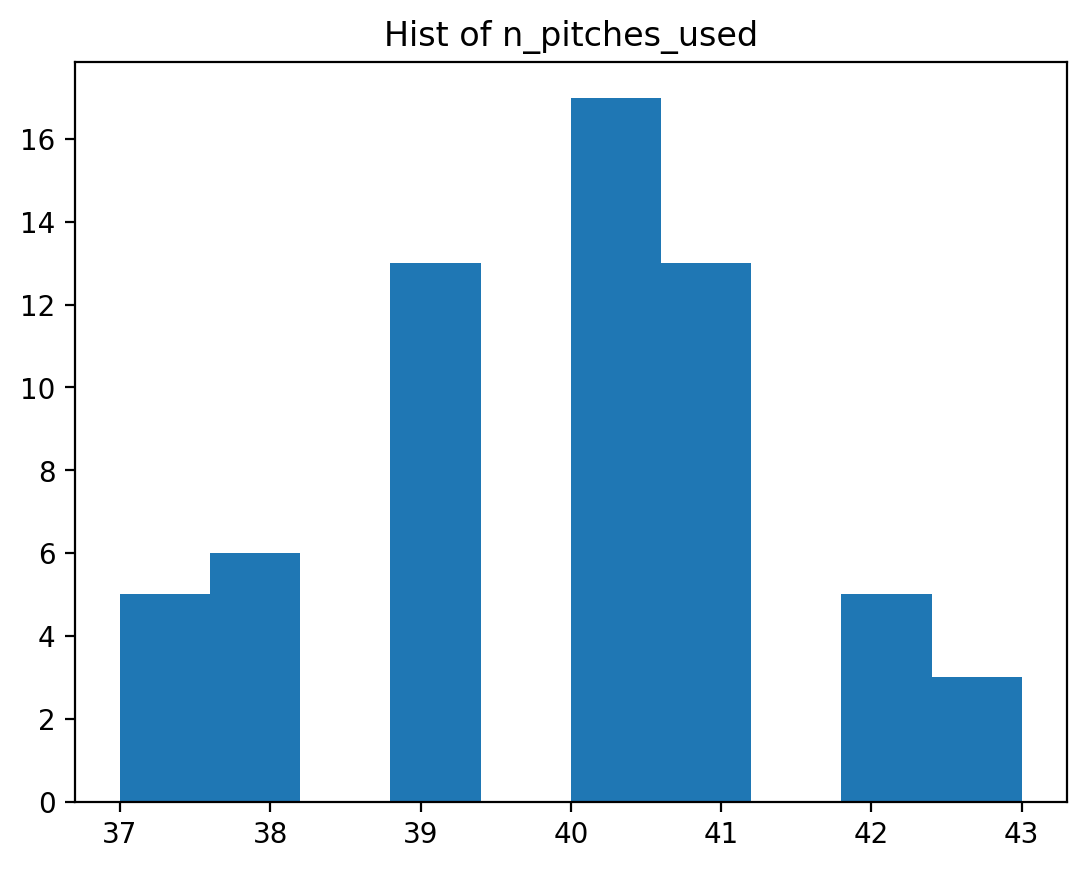

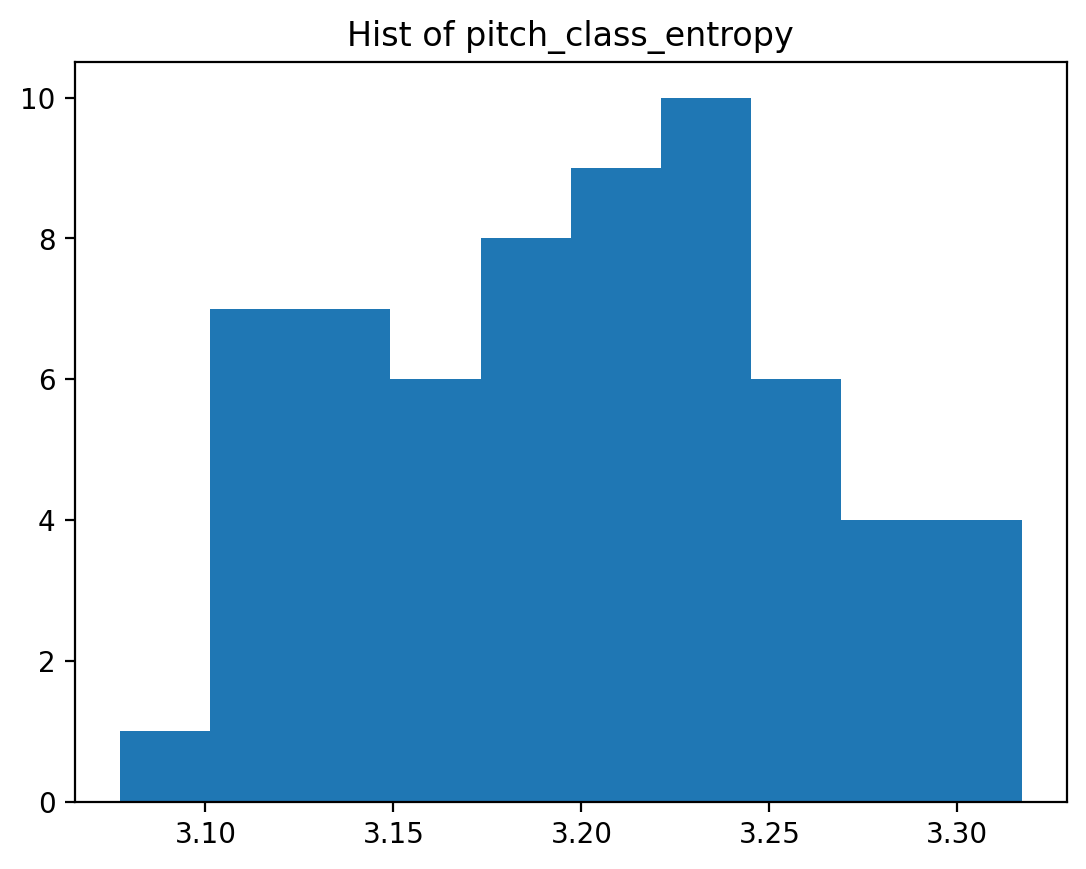

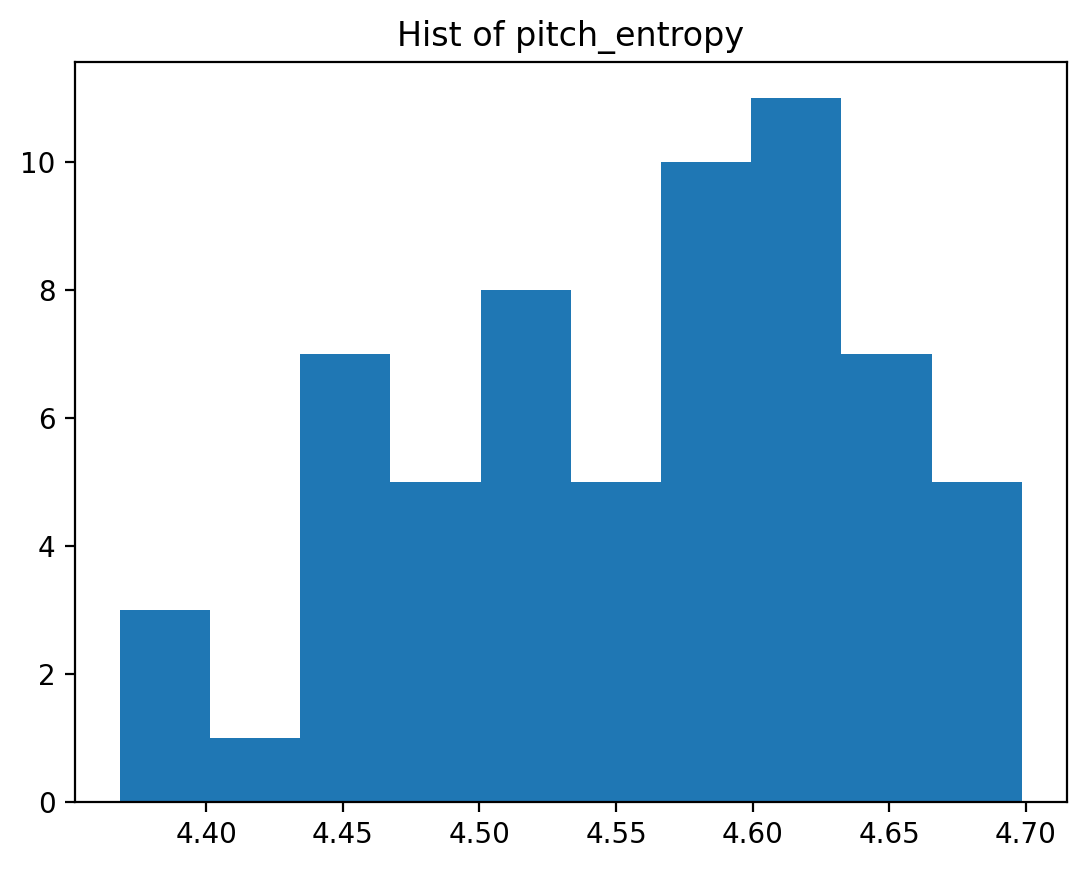

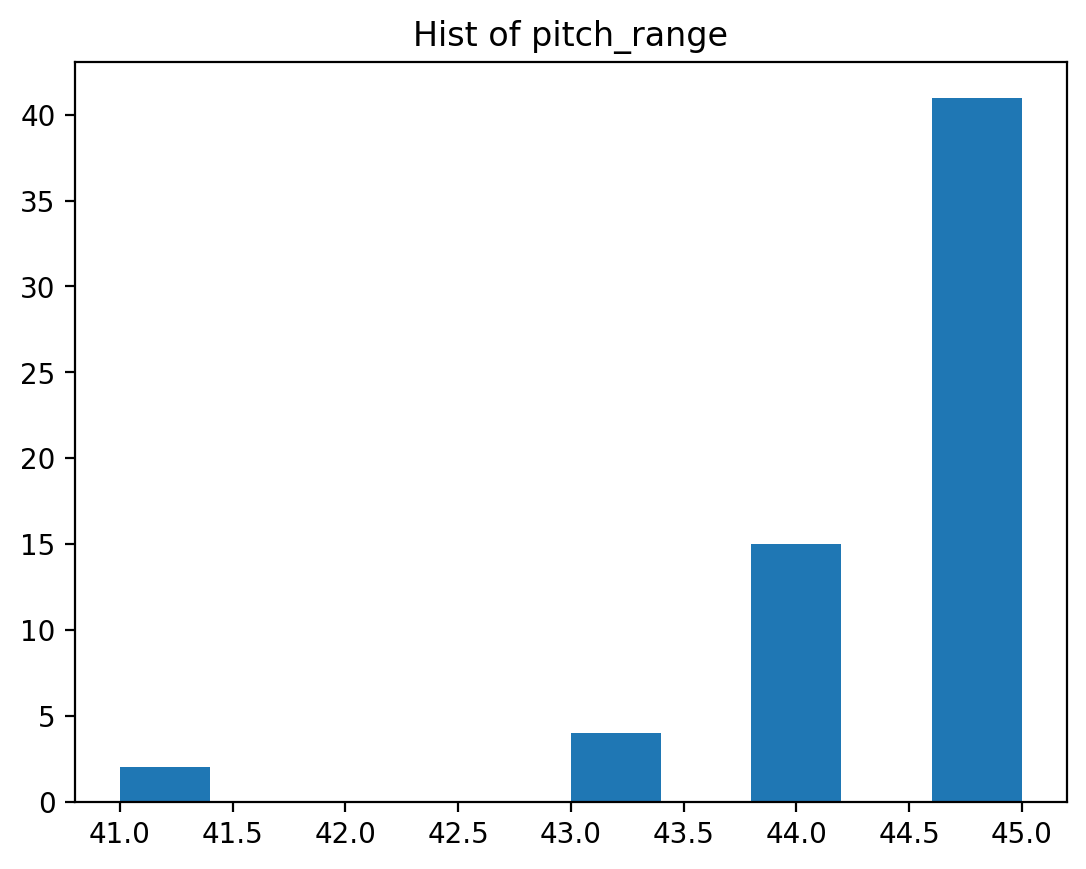

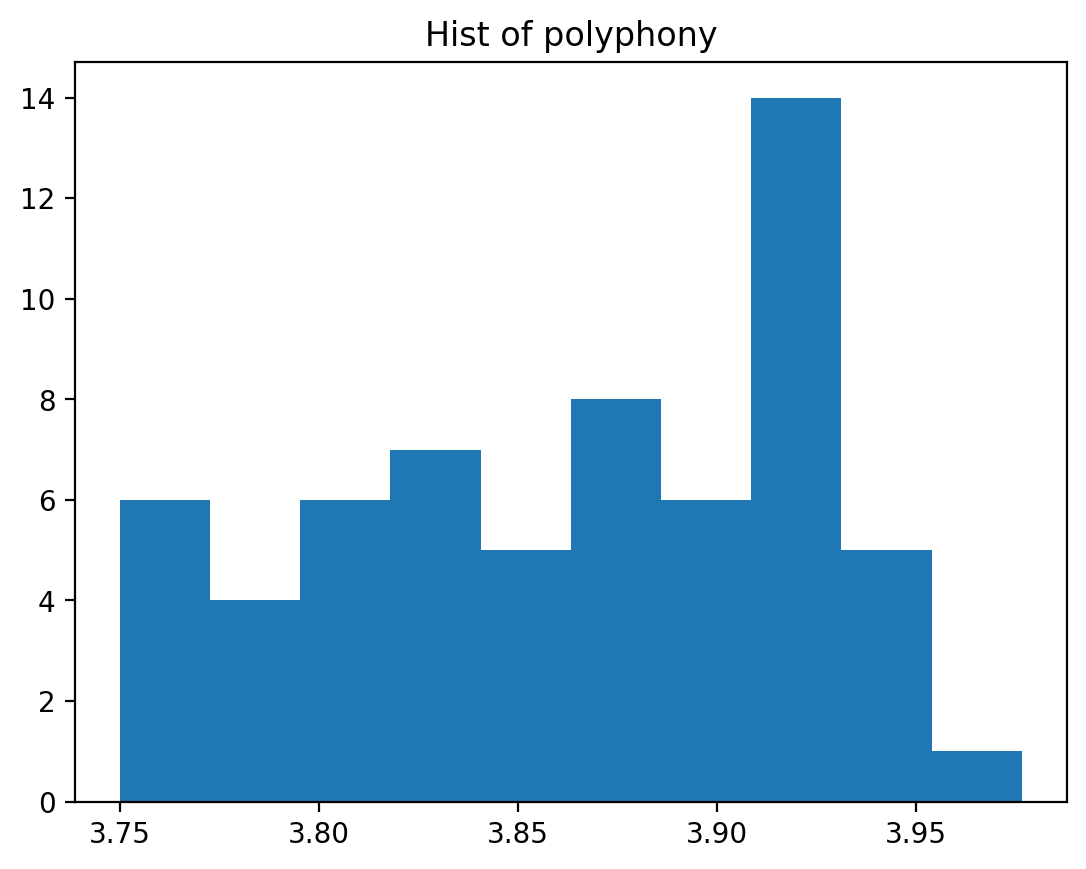

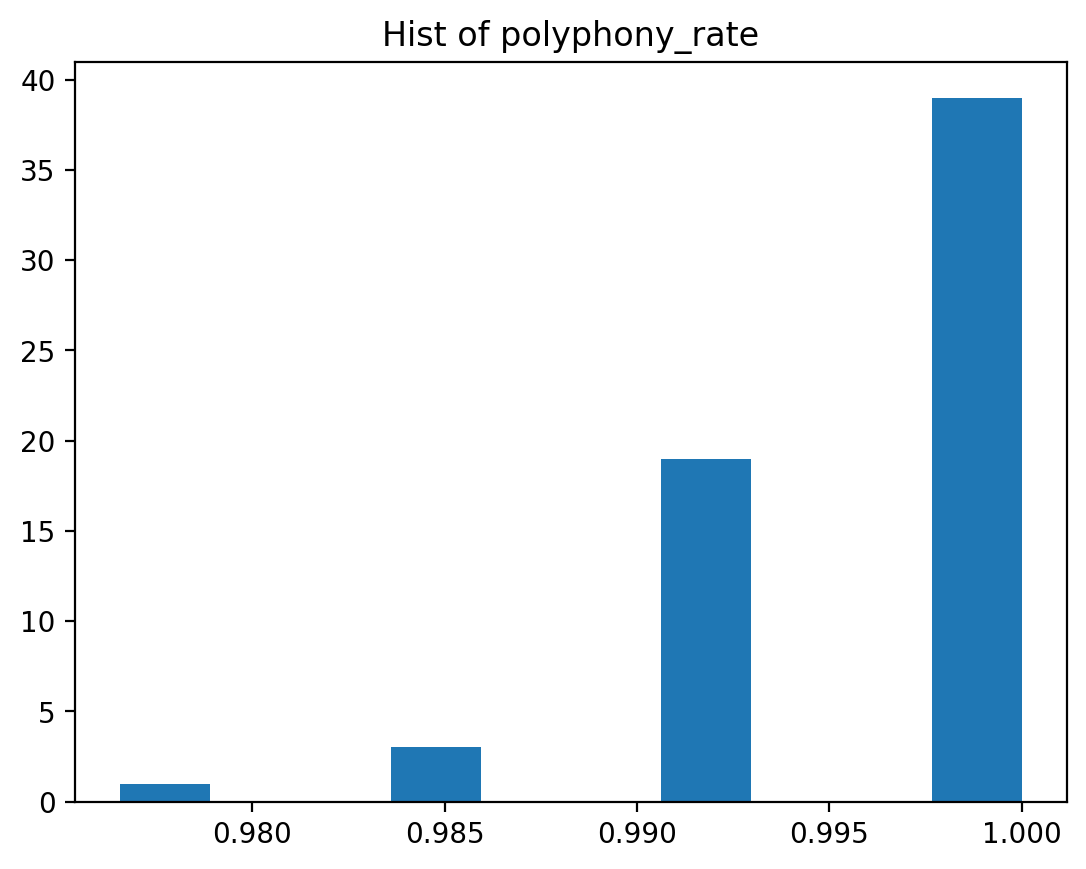

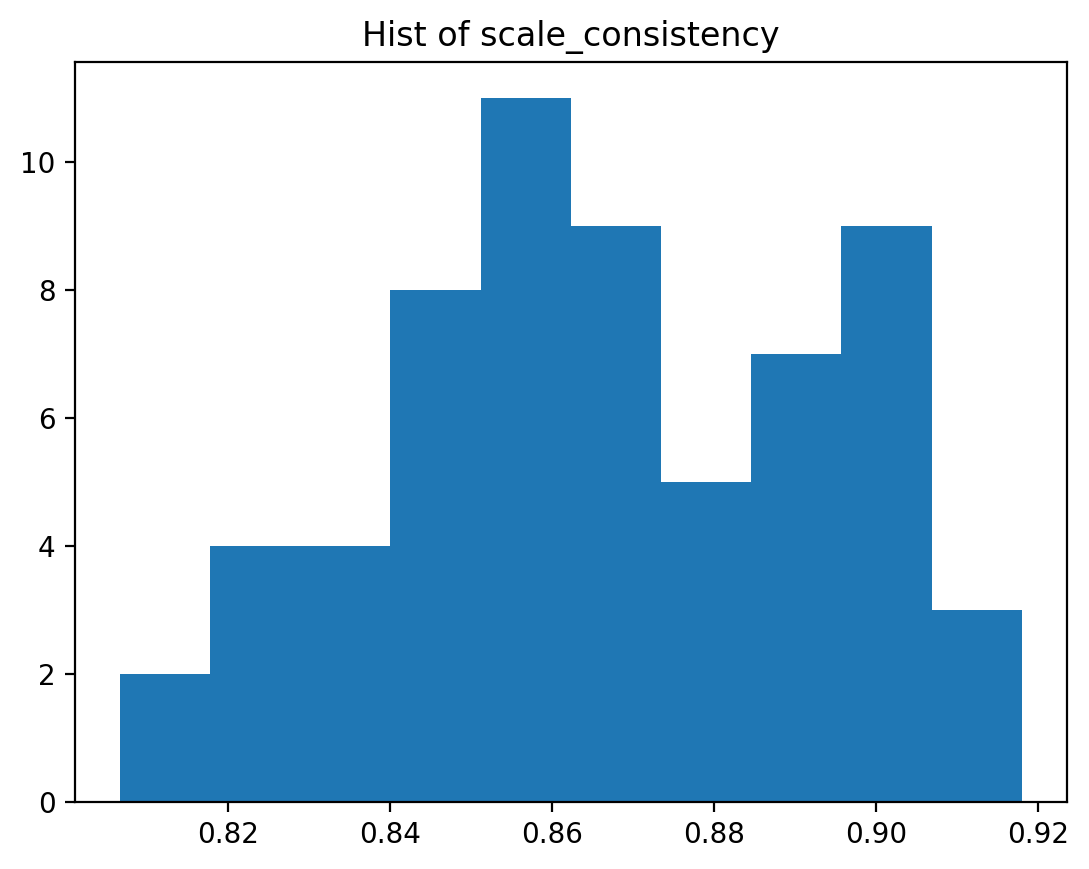



Overall:
n_pitch_classes_used : 1
n_pitches_used       : 0
pitch_class_entropy  : 0
pitch_entropy        : 0
pitch_range          : -1
polyphony            : 1
polyphony_rate       : -1
scale_consistency    : 0


In [50]:
# Run this after running the previous section to see the distribution of metrics for generated data
thresh = .75
n_pass = 0
sum = 0
for i in range(num_tracks) :
  n_neg = 0
  n_zer = 0
  n_one = 0
  for j in range(num_fields) :
    n_neg = n_neg+1 if ind_gen_results[i][j]==-1 else n_neg
    n_zer = n_zer+1 if ind_gen_results[i][j]==0  else n_zer
    n_one = n_one+1 if ind_gen_results[i][j]==1  else n_one
  print(f"track {i}: \t{n_one}/{num_fields-n_neg}")
  n_pass = n_pass+1 if (float(n_one)>float((num_fields-n_neg)*thresh)) else n_pass
  sum = sum + n_one
print(f"Overall: \t{n_pass}/{num_tracks} ({float(sum/num_tracks)}/{num_fields-n_neg})")

col_gen_metrics.plot_attr()

# Calculate for overall
print("\n\nOverall:")
# maestro_training_metrics.print_hyp_test(col_gen_metrics)

j = 0 #temp itr var for cols
alpha = 1e-19
ci = 0.05
for attr in dir(Metrics()) :
  if not callable(getattr(Metrics(), attr)) and not attr.startswith("__") :
    result = 0
    # if p_score is LEQ than specified alpha, not normal, ignore result
    if ((getattr(bach_training_metrics,attr).p_score()<=alpha and getattr(bach_training_metrics,attr).override != 1) or getattr(bach_training_metrics,attr).override == -1):
      result = -1
    else :
      # Calculate z_score = (x_bar - mu)/(sigma / sqrt(n))
      z_score = abs(getattr(col_gen_metrics,attr).mean()-getattr(bach_training_metrics,attr).mean())/(getattr(bach_training_metrics,attr).std())
      # Calculate if within probability region
      threshold = abs(stat.norm.ppf(1-(ci/2)))
      result = 1 if z_score < threshold else 0

    print("%-20s : %s" % (attr, str(result)))

## RoBertA

### Setup

In [ ]:
!pip install pretty_midi -q
!pip install mir_eval -q

In [ ]:
# Setup
# Imports
import librosa
import pretty_midi
import numpy as np
import pandas as pd 

# For plotting
import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
# For putting audio in the notebook
import IPython.display

### Validation Metrics


In [ ]:
# Load Training Data
import pickle

# function to load saved metrics file
def load_object(filename, path="/content/drive/Shareddrives/EC523_Project/CodeWorkspace/MaestroMetrics/"):
    try:
        with open(path + filename+".pickle", "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)

# Load saved training metrics
maestro_training_metrics = load_object("training_metrics")
maestro_validation_metrics = load_object("validation_metrics")

# Params and vars for generated music
num_tracks = len(maestro_validation_metrics.polyphony_rate.data)
num_fields = 8
ind_gen_results = np.zeros([num_tracks, num_fields])

# Change this to the right dir
fs = 10 # Sample frequency
for i in range(num_tracks) :
  # For all metrics' fields
  j = 0 #temp itr var for cols

  alpha = 1e-19
  ci = 0.05
  for attr in dir(Metrics()) :
      if not callable(getattr(Metrics(), attr)) and not attr.startswith("__") :
        # if p_score is LEQ than specified alpha, not normal, ignore result
        if ((getattr(maestro_training_metrics,attr).p_score()<=alpha and getattr(maestro_training_metrics,attr).override != 1) or getattr(maestro_training_metrics,attr).override == -1):
          ind_gen_results[i][j]=-1
        else :
          # Calculate z_score = (x_bar - mu)/(sigma / sqrt(n))
          z_score = abs(getattr(maestro_validation_metrics,attr).mean()-getattr(maestro_training_metrics,attr).mean())/(getattr(maestro_training_metrics,attr).std())
          # Calculate if within probability region
          threshold = abs(stat.norm.ppf(1-(ci/2)))
          ind_gen_results[i][j]= 1 if z_score < threshold else 0

        # print("%-20s : %s" % (attr, str(ind_gen_results[i][j])))
        j = j+1

# Calculate for overall
print("\n\nOverall:")
# maestro_training_metrics.print_hyp_test(col_gen_metrics)

j = 0 #temp itr var for cols
alpha = 1e-19
ci = 0.05
for attr in dir(Metrics()) :
  if not callable(getattr(Metrics(), attr)) and not attr.startswith("__") :
    result = 0
    # if p_score is LEQ than specified alpha, not normal, ignore result
    if ((getattr(maestro_training_metrics,attr).p_score()<=alpha and getattr(maestro_training_metrics,attr).override != 1) or getattr(maestro_training_metrics,attr).override == -1):
      result = -1
    else :
      # Calculate z_score = (x_bar - mu)/(sigma / sqrt(n))
      z_score = abs(getattr(maestro_validation_metrics,attr).mean()-getattr(maestro_training_metrics,attr).mean())/(getattr(maestro_training_metrics,attr).std())
      # Calculate if within probability region
      threshold = abs(stat.norm.ppf(1-(ci/2)))
      result = 1 if z_score < threshold else 0

    print("%-20s : %s" % (attr, str(result)))



# Run this after running the previous section to see the distribution of metrics for generated data
thresh = .75
n_pass = 0
for i in range(num_tracks) :
  n_neg = 0
  n_zer = 0
  n_one = 0
  for j in range(num_fields) :
    n_neg = n_neg+1 if ind_gen_results[i][j]==-1 else n_neg
    n_zer = n_zer+1 if ind_gen_results[i][j]==0  else n_zer
    n_one = n_one+1 if ind_gen_results[i][j]==1  else n_one
  print(f"track {i}: \t{n_one}/{num_fields-n_neg}")
  n_pass = n_pass+1 if (float(n_one)>float((num_fields-n_neg)*thresh)) else n_pass
print(f"Overall: \t{n_pass}/{num_tracks}")



Overall:
n_pitch_classes_used : -1
n_pitches_used       : -1
pitch_class_entropy  : 1
pitch_entropy        : 1
pitch_range          : -1
polyphony            : 1
polyphony_rate       : 1
scale_consistency    : 1
track 0: 	5/5
track 1: 	5/5
track 2: 	5/5
track 3: 	5/5
track 4: 	5/5
track 5: 	5/5
track 6: 	5/5
track 7: 	5/5
track 8: 	5/5
track 9: 	5/5
track 10: 	5/5
track 11: 	5/5
track 12: 	5/5
track 13: 	5/5
track 14: 	5/5
track 15: 	5/5
track 16: 	5/5
track 17: 	5/5
track 18: 	5/5
track 19: 	5/5
track 20: 	5/5
track 21: 	5/5
track 22: 	5/5
track 23: 	5/5
track 24: 	5/5
track 25: 	5/5
track 26: 	5/5
track 27: 	5/5
track 28: 	5/5
track 29: 	5/5
track 30: 	5/5
track 31: 	5/5
track 32: 	5/5
track 33: 	5/5
track 34: 	5/5
track 35: 	5/5
track 36: 	5/5
track 37: 	5/5
track 38: 	5/5
track 39: 	5/5
track 40: 	5/5
track 41: 	5/5
track 42: 	5/5
track 43: 	5/5
track 44: 	5/5
track 45: 	5/5
track 46: 	5/5
track 47: 	5/5
track 48: 	5/5
track 49: 	5/5
track 50: 	5/5
track 51: 	5/5
track 52: 	5/5
t

### Gen Metrics

In [29]:
# Load Training Data
import pickle


# function to load saved metrics file
def load_object(filename, path="/content/drive/Shareddrives/EC523_Project/CodeWorkspace/MaestroMetrics/"):
    try:
        with open(path + filename+".pickle", "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)

# Load saved training metrics
maestro_training_metrics = load_object("training_metrics")

# Params and vars for generated music
num_tracks = 137
num_fields = 8
ind_gen_results = np.zeros([num_tracks, num_fields])
col_gen_metrics = Metrics() # collective metrics


# Change this to the right dir
PATH_STUB = '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/RoBertA_1024_30/'
fs = 10 # Sample frequency
for i in range(num_tracks) :
  pm = pretty_midi.PrettyMIDI(PATH_STUB+f'song{i}.mid')
  # estimate time-steps per quarter-note
  tempo = pm.estimate_tempo()
  bps = tempo/60.0 # beats per second
  res = round(fs/bps) if round(fs/bps) > 0 else 1 # samples per beat
  pianoroll = pm.get_piano_roll(fs=fs)
  
  print(f"Length:{pianoroll.shape[1]/fs}s")
  # Get metrics
  ind_gen_metrics = Metrics()
  ind_gen_metrics.append(getMetricsPianoroll(pianoroll))
  col_gen_metrics.append(ind_gen_metrics)

  # Evaluate metrics
  # Must run first code block of "Calculating for the Bach Chorals"
  # print(f"Track {i}")
  # maestro_training_metrics.print_hyp_test(ind_gen_metrics, alpha=1e-19)

  # For all metrics' fields
  j = 0 #temp itr var for cols

  alpha = 1e-19
  ci = 0.05
  for attr in dir(Metrics()) :
      if not callable(getattr(Metrics(), attr)) and not attr.startswith("__") :
        # if p_score is LEQ than specified alpha, not normal, ignore result
        if ((getattr(maestro_training_metrics,attr).p_score()<=alpha and getattr(maestro_training_metrics,attr).override != 1) or getattr(maestro_training_metrics,attr).override == -1):
          ind_gen_results[i][j]=-1
        else :
          # Calculate z_score = (x_bar - mu)/(sigma / sqrt(n))
          z_score = abs(getattr(ind_gen_metrics,attr).mean()-getattr(maestro_training_metrics,attr).mean())/(getattr(maestro_training_metrics,attr).std())
          # Calculate if within probability region
          threshold = abs(stat.norm.ppf(1-(ci/2)))
          ind_gen_results[i][j]= 1 if z_score < threshold else 0

        # print("%-20s : %s" % (attr, str(ind_gen_results[i][j])))
        j = j+1

# Calculate for overall
print("\n\nOverall:")
# maestro_training_metrics.print_hyp_test(col_gen_metrics)

j = 0 #temp itr var for cols
alpha = 1e-19
ci = 0.05
for attr in dir(Metrics()) :
  if not callable(getattr(Metrics(), attr)) and not attr.startswith("__") :
    result = 0
    # if p_score is LEQ than specified alpha, not normal, ignore result
    if ((getattr(maestro_training_metrics,attr).p_score()<=alpha and getattr(maestro_training_metrics,attr).override != 1) or getattr(maestro_training_metrics,attr).override == -1):
      result = -1
    else :
      # Calculate z_score = (x_bar - mu)/(sigma / sqrt(n))
      z_score = abs(getattr(col_gen_metrics,attr).mean()-getattr(maestro_training_metrics,attr).mean())/(getattr(maestro_training_metrics,attr).std())
      # Calculate if within probability region
      threshold = abs(stat.norm.ppf(1-(ci/2)))
      result = 1 if z_score < threshold else 0

    print("%-20s : %s" % (attr, str(result)))


Length:748.0s
Length:214.0s
Length:703.1s
Length:348.0s
Length:151.0s
Length:135.9s
Length:932.1s
Length:770.0s
Length:159.5s
Length:165.0s
Length:150.5s
Length:154.6s
Length:403.5s
Length:717.8s
Length:124.4s
Length:390.0s
Length:122.5s
Length:1442.6s
Length:930.0s
Length:695.6s
Length:340.4s
Length:707.5s
Length:64.6s
Length:133.5s
Length:246.9s
Length:703.5s
Length:346.7s
Length:270.0s
Length:254.1s
Length:1150.0s
Length:262.0s
Length:588.8s
Length:838.9s
Length:25.5s
Length:43.6s
Length:181.3s
Length:270.1s
Length:90.0s
Length:79.8s
Length:54.2s
Length:203.1s
Length:199.9s
Length:365.1s
Length:100.1s
Length:138.2s
Length:168.0s
Length:964.3s
Length:94.0s
Length:64.0s
Length:1102.5s
Length:258.5s
Length:504.0s
Length:199.9s
Length:225.6s
Length:244.3s
Length:955.9s
Length:211.3s
Length:424.1s
Length:408.6s
Length:148.0s
Length:1064.4s
Length:354.0s
Length:70.0s
Length:188.2s
Length:149.5s
Length:332.3s
Length:333.0s
Length:360.7s
Length:269.4s
Length:78.5s
Length:401.2s
Length:82.6s

In [ ]:
# Run this after running the previous section to see the distribution of metrics for generated data
thresh = .75
n_pass = 0
sum = 0
for i in range(num_tracks) :
  n_neg = 0
  n_zer = 0
  n_one = 0
  for j in range(num_fields) :
    n_neg = n_neg+1 if ind_gen_results[i][j]==-1 else n_neg
    n_zer = n_zer+1 if ind_gen_results[i][j]==0  else n_zer
    n_one = n_one+1 if ind_gen_results[i][j]==1  else n_one
  print(f"track {i}: \t{n_one}/{num_fields-n_neg}")
  n_pass = n_pass+1 if (float(n_one)>float((num_fields-n_neg)*thresh)) else n_pass
  sum = sum + n_one
print(f"Overall: \t{n_pass}/{num_tracks} ({float(sum/num_tracks)}/{num_fields-n_neg})")

col_gen_metrics.plot_attr()

# Calculate for overall
print("\n\nOverall:")
# maestro_training_metrics.print_hyp_test(col_gen_metrics)

j = 0 #temp itr var for cols
alpha = 1e-19
ci = 0.05
for attr in dir(Metrics()) :
  if not callable(getattr(Metrics(), attr)) and not attr.startswith("__") :
    result = 0
    # if p_score is LEQ than specified alpha, not normal, ignore result
    if ((getattr(maestro_training_metrics,attr).p_score()<=alpha and getattr(maestro_training_metrics,attr).override != 1) or getattr(maestro_training_metrics,attr).override == -1):
      result = -1
    else :
      # Calculate z_score = (x_bar - mu)/(sigma / sqrt(n))
      z_score = abs(getattr(col_gen_metrics,attr).mean()-getattr(maestro_training_metrics,attr).mean())/(getattr(maestro_training_metrics,attr).std())
      # Calculate if within probability region
      threshold = abs(stat.norm.ppf(1-(ci/2)))
      result = 1 if z_score < threshold else 0

    print("%-20s : %s" % (attr, str(result)))

## GPT

In [43]:
!pip install pretty_midi -q
!pip install mir_eval -q

In [44]:
# Setup
# Imports
import librosa
import pretty_midi
import numpy as np
import pandas as pd 
import glob

# For plotting
import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
# For putting audio in the notebook
import IPython.display

In [59]:
# Load Training Data
import pickle


# function to load saved metrics file
def load_object(filename, path="/content/drive/Shareddrives/EC523_Project/CodeWorkspace/MaestroMetrics/"):
    try:
        with open(path + filename+".pickle", "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)

# Load saved training metrics
maestro_training_metrics = load_object("training_metrics")

# Load pieces
music_files = glob.glob("/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/GPTmini/temp06topk5/*")
# music_files = glob.glob("/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/GPTmini/*")
print(music_files)

# Params and vars for generated music
num_tracks = len(music_files)
num_fields = 8
ind_gen_results = np.zeros([num_tracks, num_fields])
col_gen_metrics = Metrics() # collective metrics

i = 0
# Change this to the right dir
fs = 10 # Sample frequency
for track in music_files :
  # if (track.startswith('/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/GPTmini/usesong')) :
    pm = pretty_midi.PrettyMIDI(track)
    # estimate time-steps per quarter-note
    tempo = pm.estimate_tempo()
    bps = tempo/60.0 # beats per second
    res = round(fs/bps) if round(fs/bps) > 0 else 1 # samples per beat
    pianoroll = pm.get_piano_roll(fs=fs)
    print(f"Length:{pianoroll.shape[1]/fs}s")
    # Get metrics
    ind_gen_metrics = Metrics()
    ind_gen_metrics.append(getMetricsPianoroll(pianoroll))
    col_gen_metrics.append(ind_gen_metrics)

    # Evaluate metrics
    # Must run first code block of "Calculating for the Bach Chorals"
    print(f"Track {i}")
    # maestro_training_metrics.print_hyp_test(ind_gen_metrics, alpha=1e-19)

    # For all metrics' fields
    j = 0 #temp itr var for cols
    alpha = 1e-19
    ci = 0.05
    for attr in dir(Metrics()) :
        if not callable(getattr(Metrics(), attr)) and not attr.startswith("__") :
          # if p_score is LEQ than specified alpha, not normal, ignore result
          if ((getattr(maestro_training_metrics,attr).p_score()<=alpha and getattr(maestro_training_metrics,attr).override != 1) or getattr(maestro_training_metrics,attr).override == -1):
            ind_gen_results[i][j]=-1
          else :
            # Calculate z_score = (x_bar - mu)/(sigma / sqrt(n))
            z_score = abs(getattr(ind_gen_metrics,attr).mean()-getattr(maestro_training_metrics,attr).mean())/(getattr(maestro_training_metrics,attr).std())
            # Calculate if within probability region
            threshold = abs(stat.norm.ppf(1-(ci/2)))
            ind_gen_results[i][j]= 1 if z_score < threshold else 0

          # print("%-20s : %s" % (attr, str(ind_gen_results[i][j])))
          j = j+1
    i = i+1

# Calculate for overall
print("\n\nOverall:")
# maestro_training_metrics.print_hyp_test(col_gen_metrics)

j = 0 #temp itr var for cols
alpha = 1e-19
ci = 0.05
for attr in dir(Metrics()) :
  if not callable(getattr(Metrics(), attr)) and not attr.startswith("__") :
    result = 0
    # if p_score is LEQ than specified alpha, not normal, ignore result
    if ((getattr(maestro_training_metrics,attr).p_score()<=alpha and getattr(maestro_training_metrics,attr).override != 1) or getattr(maestro_training_metrics,attr).override == -1):
      result = -1
    else :
      # Calculate z_score = (x_bar - mu)/(sigma / sqrt(n))
      z_score = abs(getattr(col_gen_metrics,attr).mean()-getattr(maestro_training_metrics,attr).mean())/(getattr(maestro_training_metrics,attr).std())
      # Calculate if within probability region
      threshold = abs(stat.norm.ppf(1-(ci/2)))
      result = 1 if z_score < threshold else 0

    print("%-20s : %s" % (attr, str(result)))

['/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/GPTmini/temp06topk5/5.mid', '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/GPTmini/temp06topk5/4.mid', '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/GPTmini/temp06topk5/3.mid', '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/GPTmini/temp06topk5/2.mid', '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/GPTmini/temp06topk5/1.mid', '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/GPTmini/temp06topk5/0.mid', '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/GPTmini/temp06topk5/14.mid', '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/GPTmini/temp06topk5/13.mid', '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/GPTmini/temp06topk5/12.mid', '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/GPTmini/temp06topk5/11.mid', '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/GPTmini/tem

track 0: 	3/5
track 1: 	1/5
track 2: 	1/5
track 3: 	1/5
track 4: 	1/5
track 5: 	5/5
track 6: 	2/5
track 7: 	2/5
track 8: 	5/5
track 9: 	3/5
track 10: 	3/5
track 11: 	3/5
track 12: 	2/5
track 13: 	3/5
track 14: 	2/5
track 15: 	4/5
track 16: 	5/5
track 17: 	4/5
track 18: 	5/5
track 19: 	2/5
track 20: 	1/5
track 21: 	1/5
track 22: 	2/5
track 23: 	2/5
track 24: 	1/5
track 25: 	2/5
track 26: 	4/5
track 27: 	5/5
track 28: 	4/5
track 29: 	5/5
track 30: 	1/5
track 31: 	5/5
track 32: 	5/5
track 33: 	2/5
track 34: 	2/5
track 35: 	1/5
track 36: 	1/5
track 37: 	0/5
track 38: 	5/5
track 39: 	3/5
track 40: 	1/5
track 41: 	2/5
track 42: 	0/5
track 43: 	2/5
track 44: 	4/5
track 45: 	0/8
track 46: 	0/8
track 47: 	0/8
track 48: 	0/8
track 49: 	0/8
track 50: 	0/8
track 51: 	0/8
track 52: 	0/8
track 53: 	0/8
Overall: 	14/54 (2.185185185185185/8)


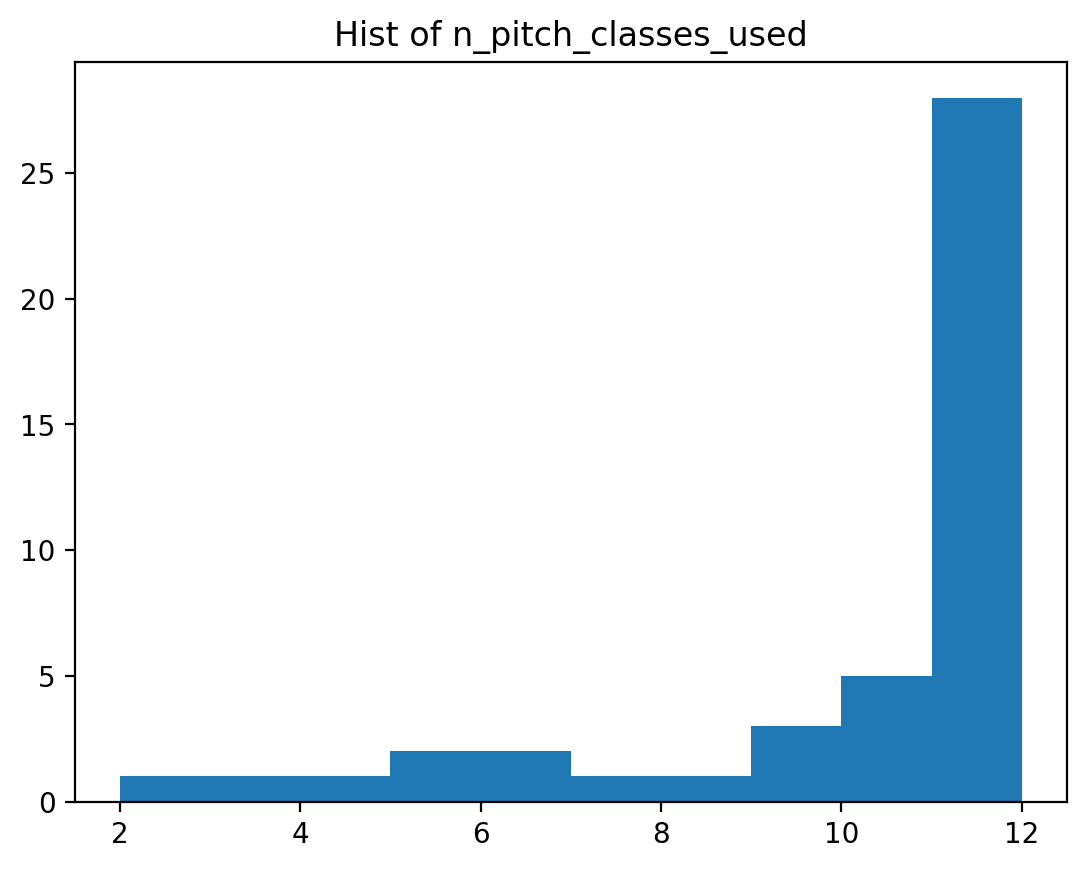

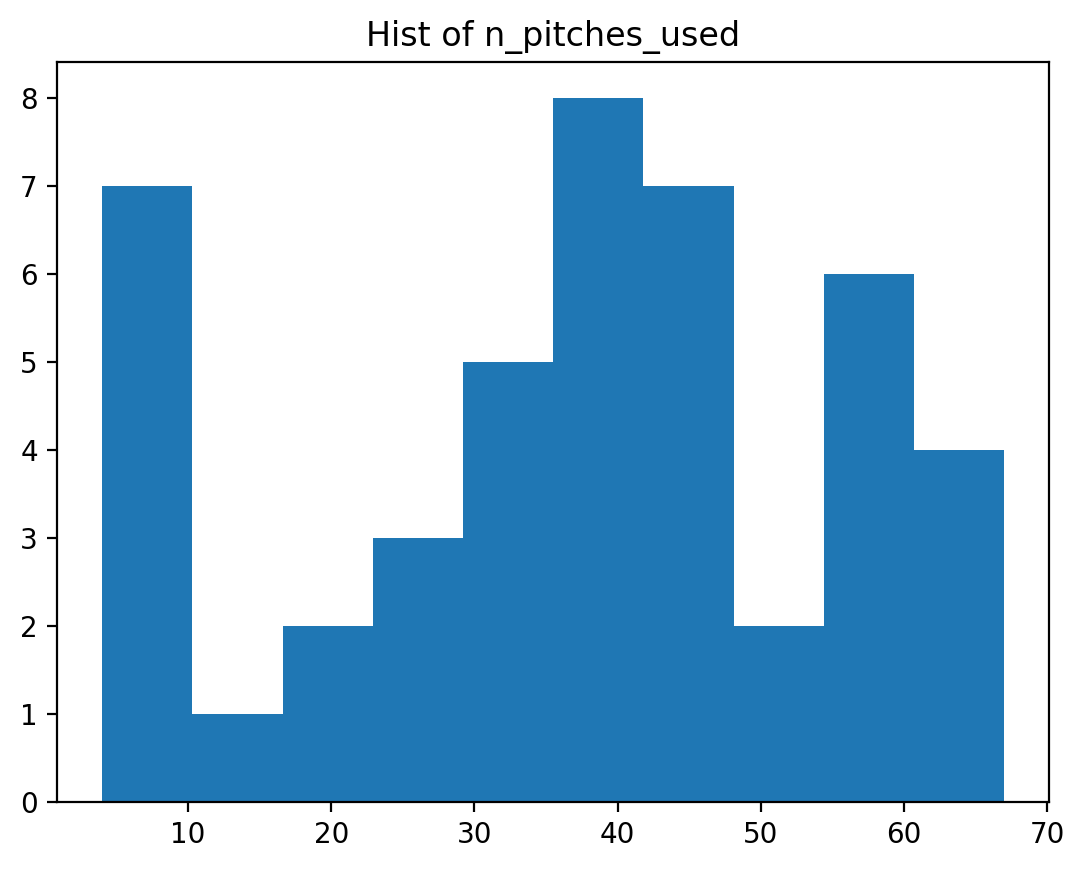

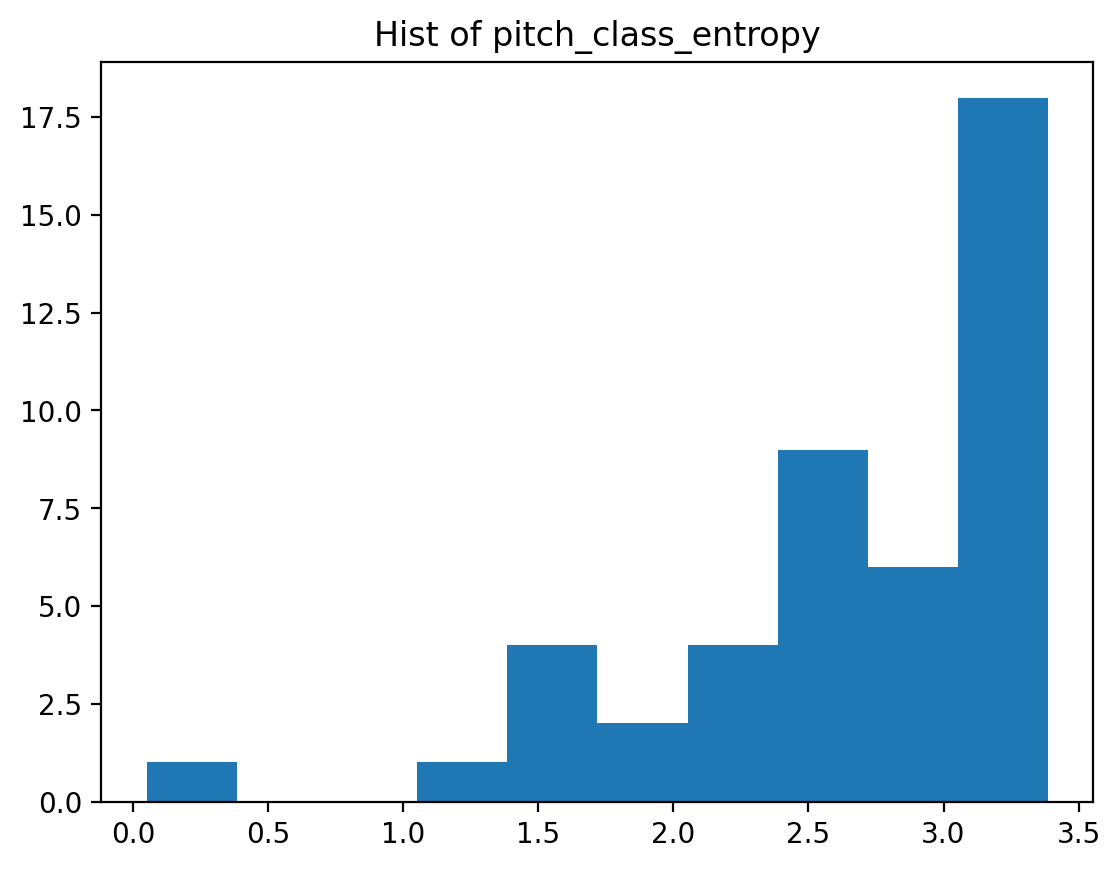

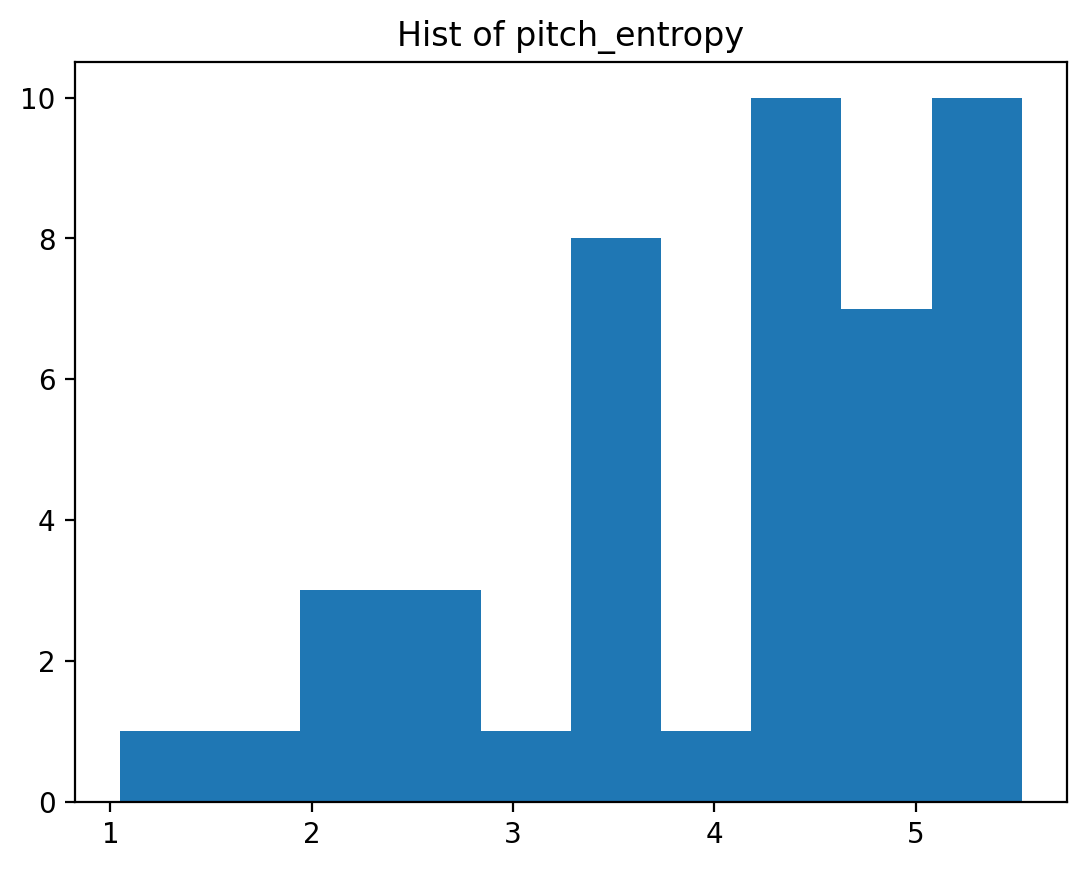

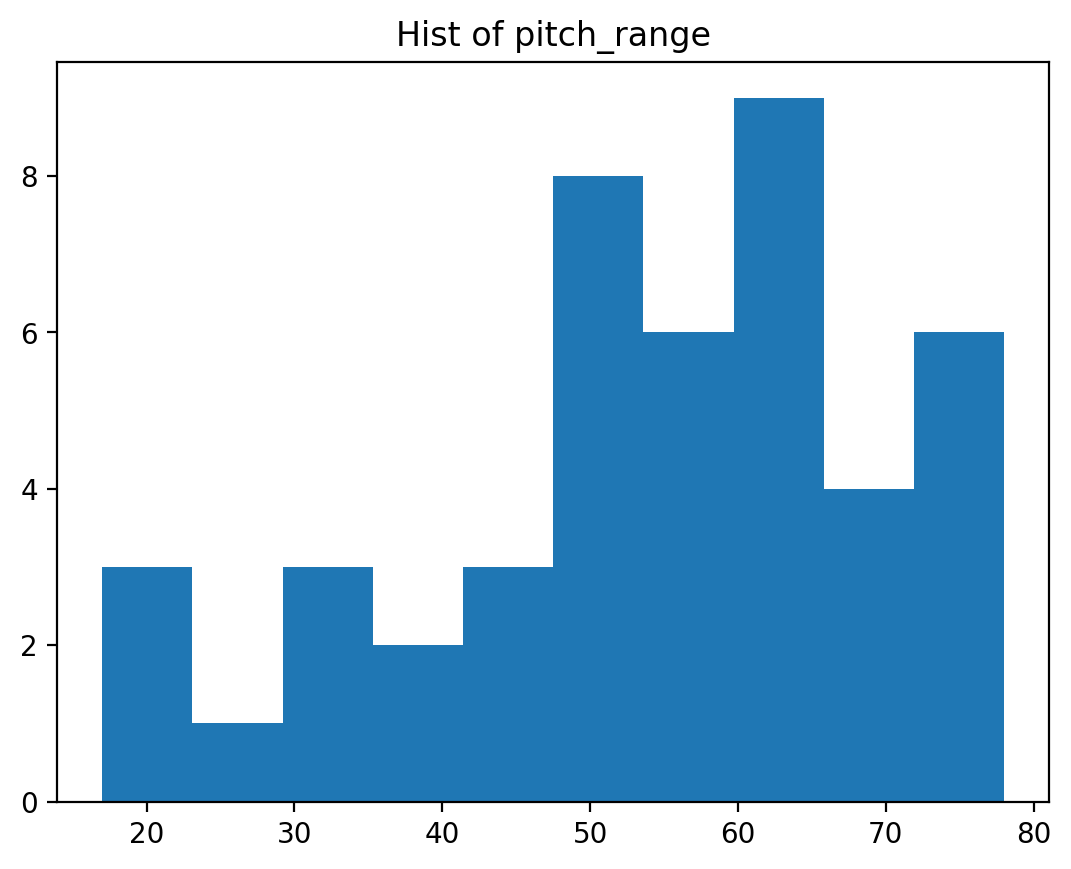

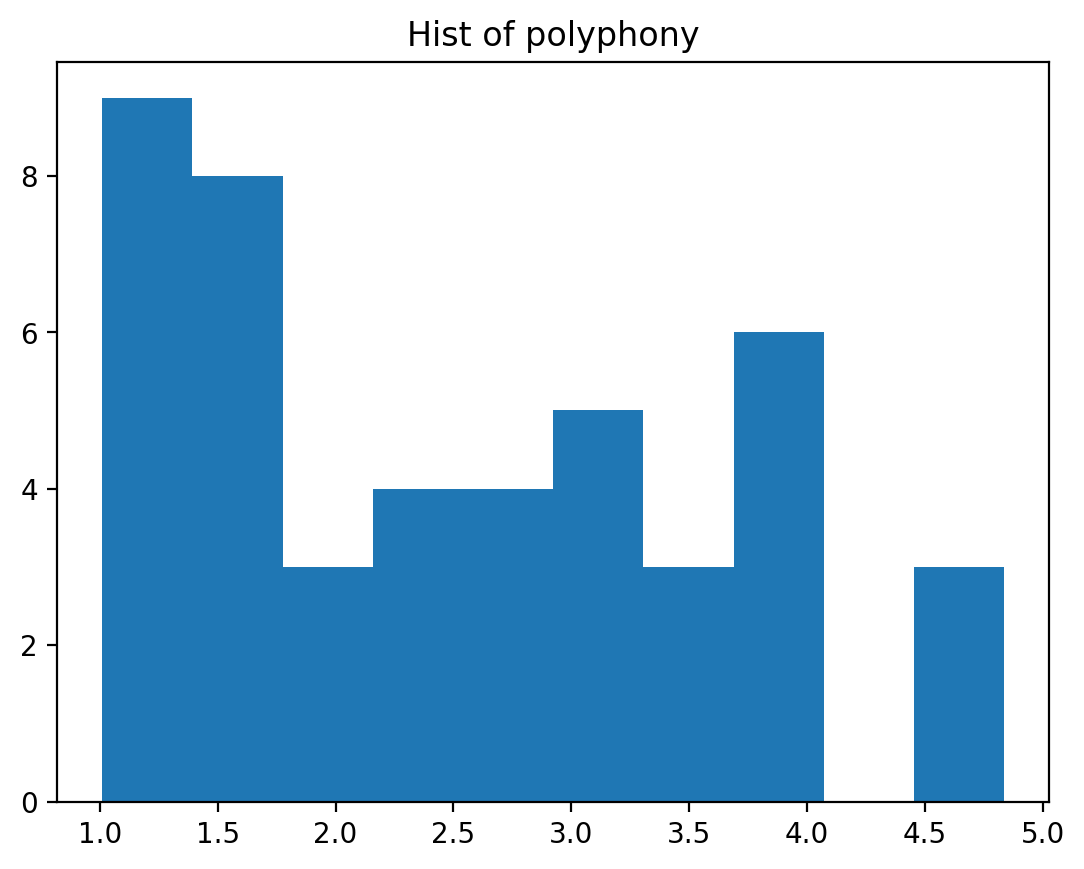

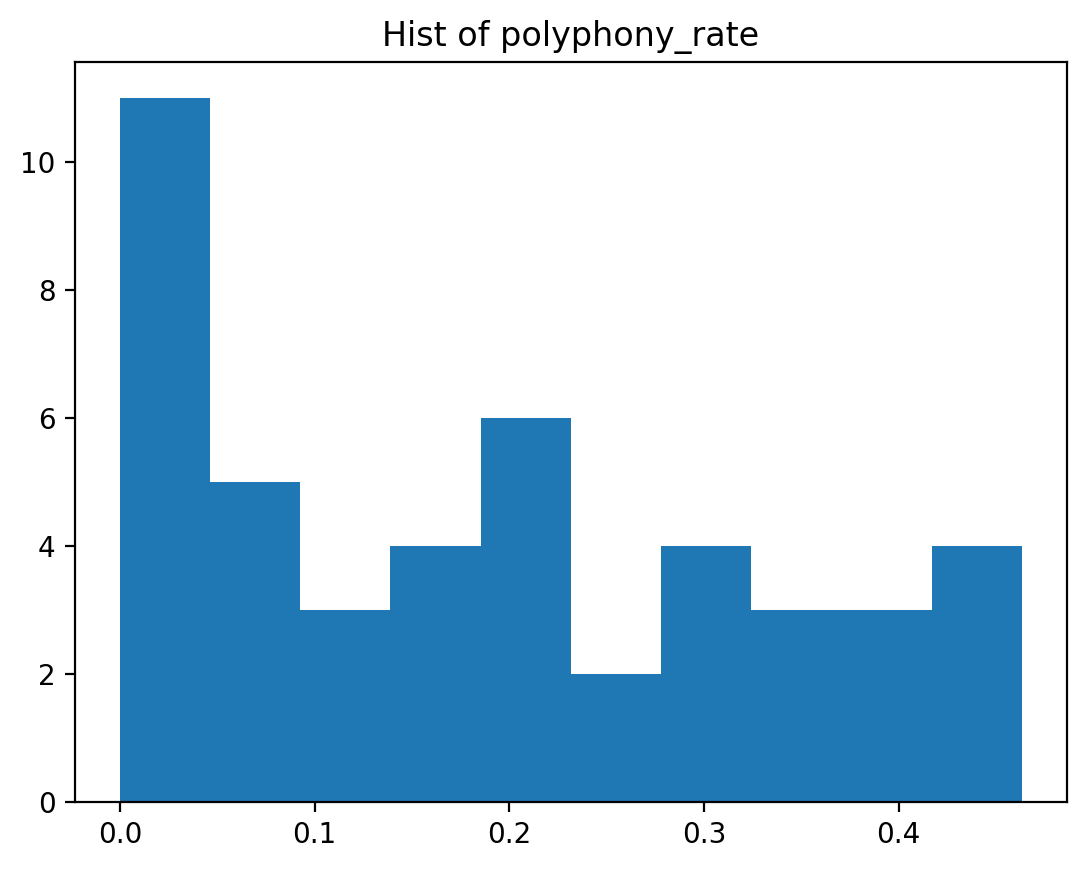

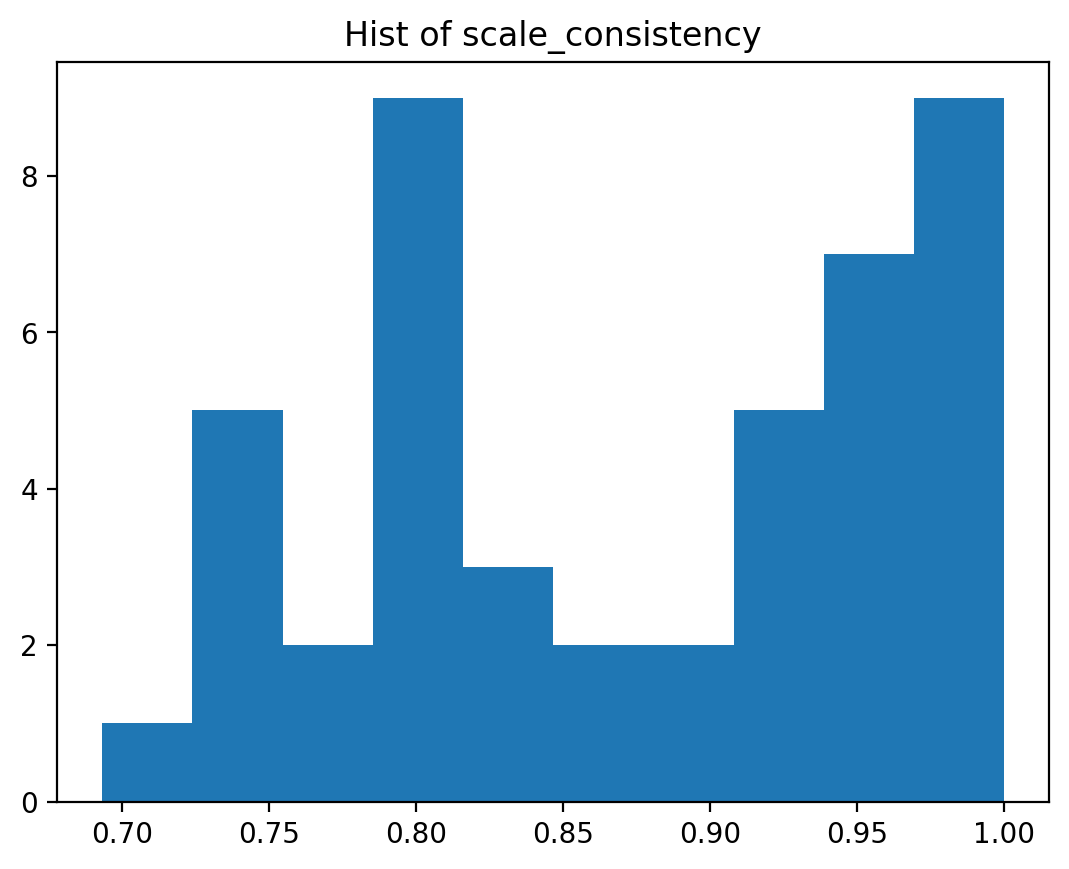



Overall:
n_pitch_classes_used : -1
n_pitches_used       : -1
pitch_class_entropy  : 0
pitch_entropy        : 0
pitch_range          : -1
polyphony            : 1
polyphony_rate       : 0
scale_consistency    : 1


In [58]:
# Run this after running the previous section to see the distribution of metrics for generated data
thresh = .75
n_pass = 0
sum = 0
for i in range(num_tracks) :
  n_neg = 0
  n_zer = 0
  n_one = 0
  for j in range(num_fields) :
    n_neg = n_neg+1 if ind_gen_results[i][j]==-1 else n_neg
    n_zer = n_zer+1 if ind_gen_results[i][j]==0  else n_zer
    n_one = n_one+1 if ind_gen_results[i][j]==1  else n_one
  print(f"track {i}: \t{n_one}/{num_fields-n_neg}")
  n_pass = n_pass+1 if (float(n_one)>float((num_fields-n_neg)*thresh)) else n_pass
  sum = sum + n_one
print(f"Overall: \t{n_pass}/{num_tracks} ({float(sum/num_tracks)}/{num_fields-n_neg})")

col_gen_metrics.plot_attr()

# Calculate for overall
print("\n\nOverall:")
# maestro_training_metrics.print_hyp_test(col_gen_metrics)

j = 0 #temp itr var for cols
alpha = 1e-19
ci = 0.05
for attr in dir(Metrics()) :
  if not callable(getattr(Metrics(), attr)) and not attr.startswith("__") :
    result = 0
    # if p_score is LEQ than specified alpha, not normal, ignore result
    if ((getattr(maestro_training_metrics,attr).p_score()<=alpha and getattr(maestro_training_metrics,attr).override != 1) or getattr(maestro_training_metrics,attr).override == -1):
      result = -1
    else :
      # Calculate z_score = (x_bar - mu)/(sigma / sqrt(n))
      z_score = abs(getattr(col_gen_metrics,attr).mean()-getattr(maestro_training_metrics,attr).mean())/(getattr(maestro_training_metrics,attr).std())
      # Calculate if within probability region
      threshold = abs(stat.norm.ppf(1-(ci/2)))
      result = 1 if z_score < threshold else 0

    print("%-20s : %s" % (attr, str(result)))